# EDA & Hypothesis Testing

What makes a prospect a pick? I've collected all this data but what will really matter when predicting a round a prospect will be picked in. Eventually, I would like to model for the 6 position groups I identified when preprocessing my data. For now, I'll work on the total dataset as one.

Before I start modeling, I want to check out my data and get to know what will matter when trying to nail down just which round a prospect will be selected in. I start by visualizing the distribution of my outcome in a given position group. From there I pass each variable I think I may want in my model.

First things first, I need to load in my libraries.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import scipy
from scipy.stats import chisquare

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# setting format for readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_pickle('../../mod5project/pickle_files/cleaned_df')

In [4]:
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
0,Shaun Alexander,RB,Alabama,2000,72,218,4.58,17.23,9.70,59.13,3.53,2.13,Seattle Seahawks,1st,19th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,11.00,302.00,1383.00,4.60,19.00,25.00,323.00,12.90,4.00,327.00,1706.00,5.20,23.00,27.45,125.73,1.73,2.27,29.36,0.36,29.73,155.09,2.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,24.00,0.00,0.00,144.00,0.00,2.18,0.00,0.00,13.09,72,0,Receivers
1,LaVar Arrington,OLB,Penn State,2000,75,250,4.53,17.25,11.27,58.80,3.57,2.14,Washington Redskins,1st,2nd pick,2000,12.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,2.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,LBs
2,John Baker,P,North Texas,2000,75,227,2.46,15.67,8.09,56.95,3.58,2.21,Not Drafted,Not Drafted,Not Drafted,Not Drafted,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,1.00,100.00,27.00,27.00,27.00,0.00,0.00,326.80,0.09,0.09,2.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,SpecialTeams
3,Anthony Becht,TE,West Virginia,2000,78,270,4.78,33.50,10.11,123.00,6.94,4.08,New York Jets,1st,27th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

## Functions

In [5]:
def plot_outcomes(df):
    """
    This function returns the count for each round and graphs it. Along with the count,
    it will also print the normalized count -- % to total -- as a point of comparison.
    
    Parameters:
        df: original dataframe that read in cleaned data
    
    Returns:
        Dataframe shape, value counts for each round and the countplot for the distribution
        
    """
    dataframe = df
    print('Round Count: ')
    print('-'*40)
    print('DF Shape: ', dataframe.shape)
    print(dataframe['Round'].value_counts())
    print(round(dataframe['Round'].value_counts(normalize=True), 2))
    order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
    plt.figure(figsize=(10, 6))
    sns.countplot(dataframe['Round'],order=order, palette='bright');
    plt.title('Round Distribution')
    plt.savefig('../../mod5project/images/round_distro')
    plt.show()

In [83]:
def plot_stats_box(df, lst):
    """
    The function returns the descriptive statistics for each item in a list. The list in question is a set of 
    feature I'm parsing through to determine if they're statistically significant. I want to first check their 
    distribution by plotting each feature's bar graph.
    
    Parameters:
        df: original dataframe that read in cleaned data
        lst: feature list
        
    Returns:
        Prints descriptive statistics, mean by Round for the feature and plots the distribution boxplot.
    
    """
    for i in lst:
        dataframe = df
        order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
        print(i + ' Summary:')
        print(dataframe[i].describe())
        print('-' * 40)
        print(i + ' by Round')
        print(dataframe[['Round', i]].groupby(['Round']).mean().unstack())
        plt.figure(figsize = (10,6))
        plt.title(i + ' Distribution')
        sns.boxplot(y=dataframe[i], x=dataframe['Round'], order=order)
        plt.savefig('../../mod5project/images/' + i + '_Distro')
        plt.show()

In [113]:
def plot_stats_bar(df, lst):
    """
    The function returns the descriptive statistics for each item in a list. The list in question is a set of 
    feature I'm parsing through to determine if they're statistically significant. I want to first check their 
    distribution by plotting each feature's bar graph.
    
    Parameters:
        df: original dataframe that read in cleaned data
        lst: feature list
        
    Returns:
        Prints descriptive statistics, mean by Round for the feature and plots the distribution boxplot.
    
    """
    for i in lst:
        dataframe = df
        order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
        print(i + ' Summary:')
        print(dataframe[i].describe())
        print('-' * 40)
        print(i + ' by Round')
        print(dataframe[['Round', i]].groupby(['Round']).mean().unstack())      
        feature_mean = dataframe[['Round', i]].groupby(['Round']).mean()
        feature_mean.plot(kind = 'bar', stacked = False, legend = False, figsize = (10, 6))
        plt.title(i + ' Average')
        plt.xticks()
        plt.xlabel('Round')
        plt.savefig('../../mod5project/images/' + i + 'Avg')
        plt.show()

In [80]:
df[['Completions', 'Round']].groupby(['Round']).mean().unstack()

             Round      
Completions  1st           25.93
             2nd            9.21
             3rd           10.89
             4th           11.45
             5th           10.65
             6th           19.71
             7th           14.90
             Not Drafted   15.60
dtype: float64

In [60]:
def anova_tukey(df, feature):
    """
    This function runs the ANOVA test checking for significance between a given feature and the output variable.
    
    Parameters:
        df: original dataframe that read in cleaned data
        feature: feature being tested  
        
    Returns:
        Prints ANOVA test summary and Tukey-MC analysis
    
    """
    dataframe = df
    anova_rounds = ols(feature + '~Round', data=dataframe).fit()
    anova_rounds
    anova_table = sm.stats.anova_lm(anova_rounds, type=2)
    print(anova_table)
    print('')
    mc = MultiComparison(dataframe[feature], dataframe['Round'])
    mc_results = mc.tukeyhsd()
    print(mc_results.summary())

## EDA

First things first, I need to check the distribution of my outcome. My 'Not Drafted' bucket has the most observations, 1,735 total. When I look at the rounds, they range between 400-600 observations. It doesn't appear as if I have a class imbalance, but something I could try to correct when modeling.

In [44]:
df.shape

(5492, 121)

Round Count: 
----------------------------------------
DF Shape:  (5492, 121)
Not Drafted    1735
1st             613
3rd             606
4th             594
2nd             556
5th             517
6th             441
7th             430
Name: Round, dtype: int64
Not Drafted   0.32
1st           0.11
3rd           0.11
4th           0.11
2nd           0.10
5th           0.09
6th           0.08
7th           0.08
Name: Round, dtype: float64


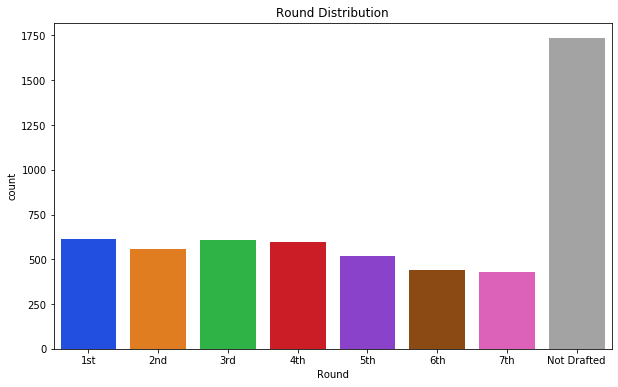

In [31]:
plot_outcomes(df)

One of the biggest assumptions I came in with was the your position, or in this case position group, helps decide your Round in the NFL draft. Below I investigate that visually.

Total Count by Position Group: 
Receivers         1812
DefensiveBacks    1101
SpecialTeams      1004
LBs                681
OffensiveLine      562
QBs                332
Name: Pos, dtype: int64
----------------------------------------
Position Group % to TTL:
Receivers        0.33
DefensiveBacks   0.20
SpecialTeams     0.18
LBs              0.12
OffensiveLine    0.10
QBs              0.06
Name: Pos, dtype: float64


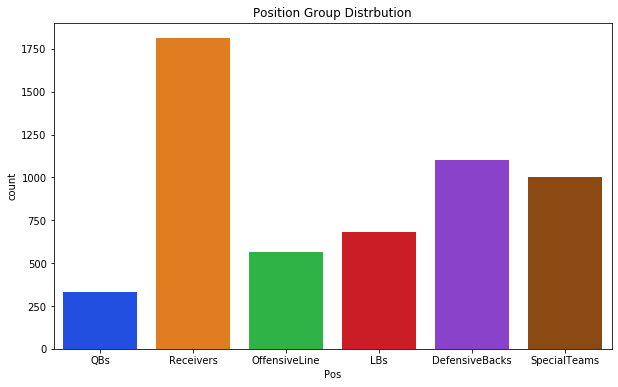

In [33]:
pos_group = df[['Pos', 'Round']]
print('Total Count by Position Group: ')
print(pos_group['Pos'].value_counts())
print('-' * 40)
print('Position Group % to TTL:')
print(pos_group['Pos'].value_counts(normalize=True))
order = ['QBs', 'Receivers', 'OffensiveLine', 'LBs', 'DefensiveBacks', 'SpecialTeams']
plt.figure(figsize=(10, 6))
sns.countplot(pos_group['Pos'], palette = 'bright', order=order)
plt.title('Position Group Distrbution')
plt.savefig('../../mod5project/images/PosGroup_Distro')
plt.show()

Overall, the Receivers group dominates the observations I have. It makes up 33% of my total dataset, where Defensive Backs makes up 20% and so on. But does that translate to how players are drafted?

1st Round Position Group Count:
Receivers         154
SpecialTeams      125
DefensiveBacks    120
OffensiveLine      90
LBs                65
QBs                59
Name: Pos, dtype: int64
----------------------------------------
1st Round Position Group % to TTL:
Receivers        0.25
SpecialTeams     0.20
DefensiveBacks   0.20
OffensiveLine    0.15
LBs              0.11
QBs              0.10
Name: Pos, dtype: float64
----------------------------------------


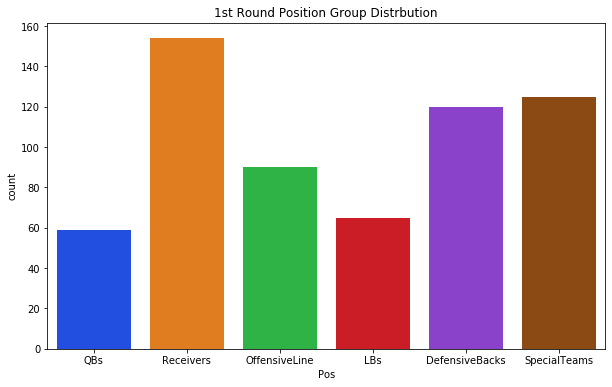

2nd Round Position Group Count:
Receivers         174
DefensiveBacks    129
SpecialTeams       90
LBs                77
OffensiveLine      65
QBs                21
Name: Pos, dtype: int64
----------------------------------------
2nd Round Position Group % to TTL:
Receivers        0.31
DefensiveBacks   0.23
SpecialTeams     0.16
LBs              0.14
OffensiveLine    0.12
QBs              0.04
Name: Pos, dtype: float64
----------------------------------------


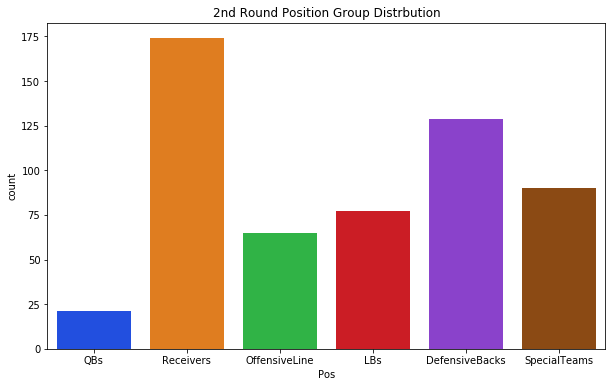

3rd Round Position Group Count:
Receivers         186
DefensiveBacks    126
SpecialTeams      105
LBs                89
OffensiveLine      75
QBs                25
Name: Pos, dtype: int64
----------------------------------------
3rd Round Position Group % to TTL:
Receivers        0.31
DefensiveBacks   0.21
SpecialTeams     0.17
LBs              0.15
OffensiveLine    0.12
QBs              0.04
Name: Pos, dtype: float64
----------------------------------------


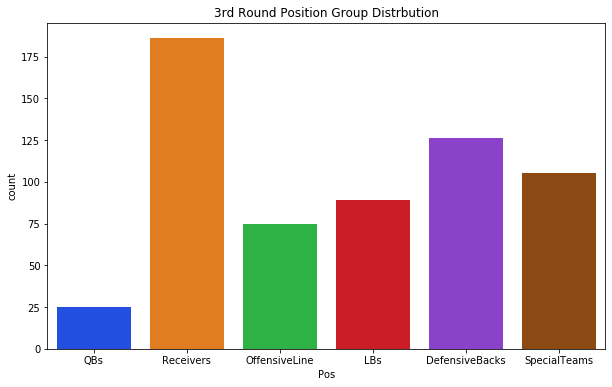

4th Round Position Group Count:
Receivers         201
DefensiveBacks    125
SpecialTeams       91
LBs                81
OffensiveLine      68
QBs                28
Name: Pos, dtype: int64
----------------------------------------
4th Round Position Group % to TTL:
Receivers        0.34
DefensiveBacks   0.21
SpecialTeams     0.15
LBs              0.14
OffensiveLine    0.11
QBs              0.05
Name: Pos, dtype: float64
----------------------------------------


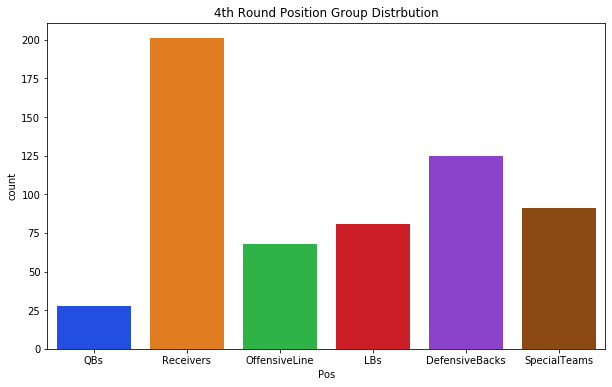

5th Round Position Group Count:
Receivers         155
DefensiveBacks    114
SpecialTeams       88
LBs                80
OffensiveLine      56
QBs                24
Name: Pos, dtype: int64
----------------------------------------
5th Round Position Group % to TTL:
Receivers        0.30
DefensiveBacks   0.22
SpecialTeams     0.17
LBs              0.15
OffensiveLine    0.11
QBs              0.05
Name: Pos, dtype: float64
----------------------------------------


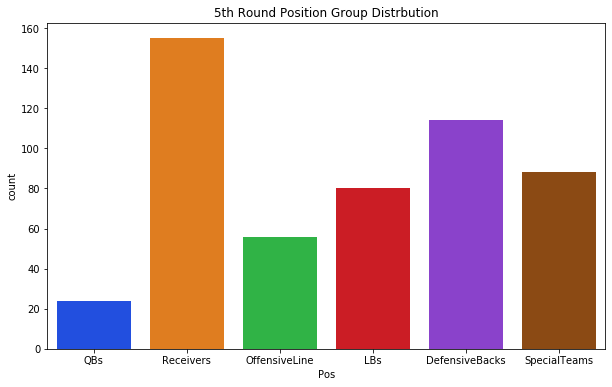

6th Round Position Group Count:
Receivers         141
DefensiveBacks     87
SpecialTeams       86
LBs                50
OffensiveLine      43
QBs                34
Name: Pos, dtype: int64
----------------------------------------
6th Round Position Group % to TTL:
Receivers        0.32
DefensiveBacks   0.20
SpecialTeams     0.20
LBs              0.11
OffensiveLine    0.10
QBs              0.08
Name: Pos, dtype: float64
----------------------------------------


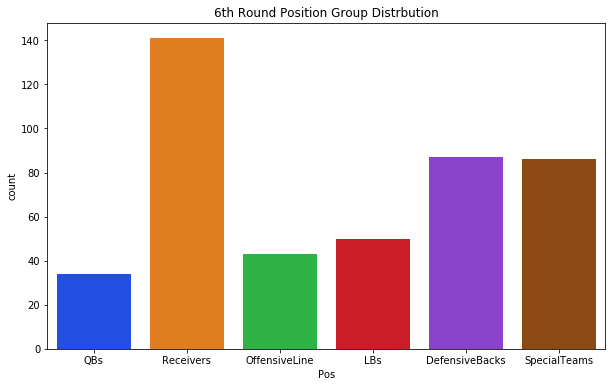

7th Round Position Group Count:
Receivers         161
SpecialTeams       85
DefensiveBacks     71
LBs                50
OffensiveLine      38
QBs                25
Name: Pos, dtype: int64
----------------------------------------
7th Round Position Group % to TTL:
Receivers        0.37
SpecialTeams     0.20
DefensiveBacks   0.17
LBs              0.12
OffensiveLine    0.09
QBs              0.06
Name: Pos, dtype: float64
----------------------------------------


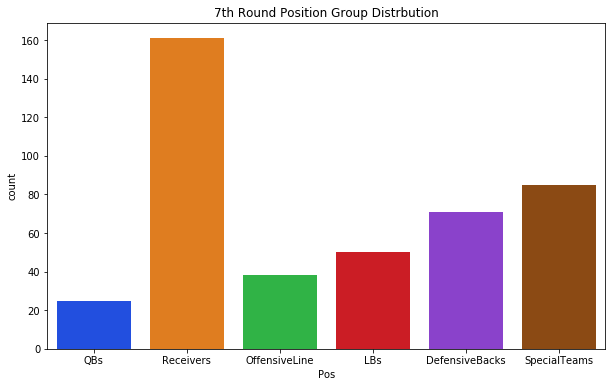

Not Drafted Round Position Group Count:
Receivers         640
SpecialTeams      334
DefensiveBacks    329
LBs               189
OffensiveLine     127
QBs               116
Name: Pos, dtype: int64
----------------------------------------
Not Drafted Round Position Group % to TTL:
Receivers        0.37
SpecialTeams     0.19
DefensiveBacks   0.19
LBs              0.11
OffensiveLine    0.07
QBs              0.07
Name: Pos, dtype: float64
----------------------------------------


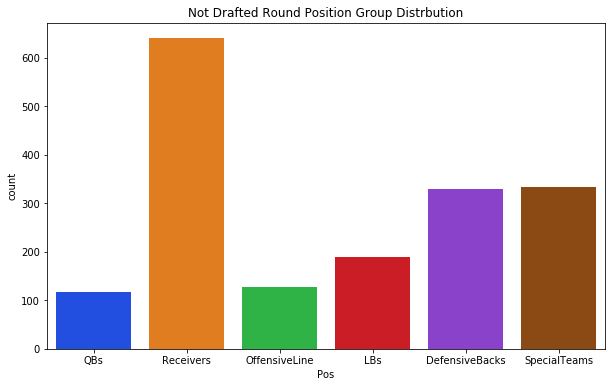

In [35]:
rounds = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
for i in rounds:
    round_df = pos_group[pos_group['Round'] == i]
    print(i + ' Round Position Group Count:')
    print(round_df['Pos'].value_counts())
    print('-' * 40)
    print(i + ' Round Position Group % to TTL:')
    print(round_df['Pos'].value_counts(normalize=True))
    print('-' * 40)
    plt.figure(figsize=(10, 6))
    sns.countplot(round_df['Pos'], palette = 'bright', order=order)
    plt.title(i + ' Round Position Group Distrbution')
    plt.savefig('../../mod5project/images/' + i + '_PosGroup_Distro')
    plt.show()

Based on the graphs above, round distribution does vary based on position group. QBs make up only 6% of the observations, but in Round 1, they represent 10% of the picks. Receivers on the other hand are only make up 24% of Round 1 picks.

### Height & Weight

In [36]:
height_weight = ['Height', 'Weight']

Height Summary:
count   5492.00
mean      73.54
std        2.59
min       65.00
25%       72.00
50%       74.00
75%       75.00
max       82.00
Name: Height, dtype: float64
----------------------------------------
Height by Round
             Height
Round              
1st           74.28
2nd           73.74
3rd           73.77
4th           73.50
5th           73.46
6th           73.41
7th           73.62
Not Drafted   73.18


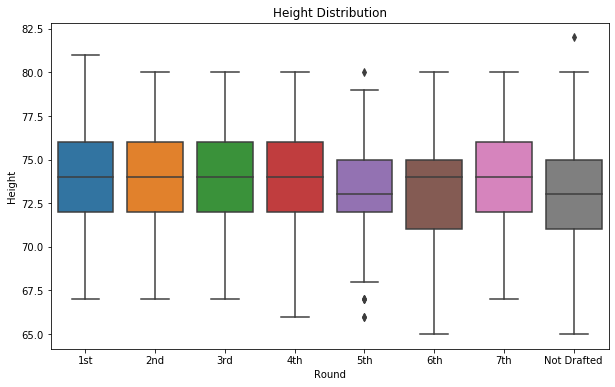

Weight Summary:
count   5492.00
mean     236.85
std       41.56
min      149.00
25%      204.00
50%      227.00
75%      260.00
max      375.00
Name: Weight, dtype: float64
----------------------------------------
Weight by Round
             Weight
Round              
1st          247.20
2nd          239.65
3rd          241.80
4th          239.05
5th          237.49
6th          235.97
7th          238.16
Not Drafted  229.53


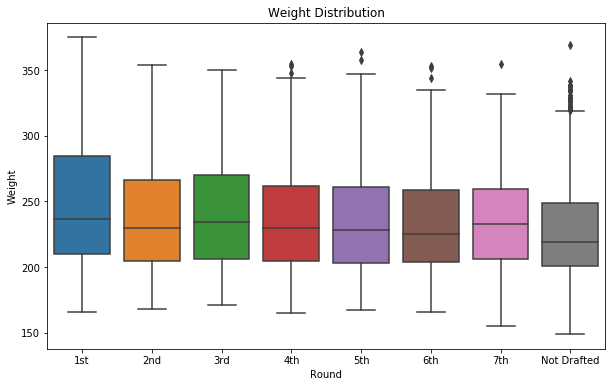

In [61]:
plot_stats_box(df, height_weight)

#### Height

H0: The height of players drafted are the same between rounds.

H1: The heigh of players drafted are not the same between rounds.

In [38]:
anova_tukey(df, 'Height')

              df   sum_sq  mean_sq     F  PR(>F)
Round       7.00   629.98    90.00 13.61    0.00
Residual 5484.00 36274.53     6.61   nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.5482 0.0067 -1.0049 -0.0915   True
   1st         3rd  -0.5099 0.0127 -0.9566 -0.0632   True
   1st         4th  -0.7872  0.001 -1.2362 -0.3382   True
   1st         5th  -0.8235  0.001 -1.2891 -0.3579   True
   1st         6th  -0.8757  0.001 -1.3626 -0.3888   True
   1st         7th  -0.6629 0.0011 -1.1534 -0.1724   True
   1st Not Drafted  -1.1011  0.001 -1.4675 -0.7347   True
   2nd         3rd   0.0383    0.9 -0.4196  0.4963  False
   2nd         4th   -0.239  0.738 -0.6991  0.2212  False
   2nd         5th  -0.2753 0.6321 -0.7517  0.2012  False
   2nd         6th  -0.3274 0.4851 -0.8247  0.1698  False
   2nd         7th  -0.1147    0.9 -0.61

Based on the test above, I can reject the null hypothesis. Height does in fact differ among the draft picks. I'll want to include this in my model.

#### Weight

H0: The weight of players drafted are the same between rounds.

H1: The weight of players drafted are not the same between rounds.

In [39]:
anova_tukey(df, 'Weight')

              df     sum_sq  mean_sq     F  PR(>F)
Round       7.00  181897.72 25985.39 15.32    0.00
Residual 5484.00 9304360.82  1696.64   nan     nan

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper   reject
-----------------------------------------------------------
   1st         2nd  -7.5445 0.0376 -14.8587  -0.2303   True
   1st         3rd   -5.402 0.2996 -12.5563   1.7522  False
   1st         4th  -8.1503 0.0138 -15.3408  -0.9598   True
   1st         5th   -9.708  0.002 -17.1655  -2.2505   True
   1st         6th -11.2269  0.001 -19.0252  -3.4286   True
   1st         7th  -9.0346 0.0116 -16.8907  -1.1785   True
   1st Not Drafted -17.6654  0.001 -23.5335 -11.7973   True
   2nd         3rd   2.1425    0.9  -5.1918   9.4768  False
   2nd         4th  -0.6057    0.9  -7.9754   6.7639  False
   2nd         5th  -2.1635    0.9  -9.7939   5.4669  False
   2nd         6th  -3.6824 0.8412 -11.6461   4.2814  False
   2nd

Once again, I reject the null hypothesis and will include Weight when predicting round pick.

### Combine Stats

First, I want to look at the descriptive statistics for the combine results.

In [40]:
combine_stats = ['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']
df[combine_stats].describe()

,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,4.61,29.34,16.70,101.48,5.75,3.50
std,0.58,7.99,7.42,26.08,1.91,1.15
min,2.23,11.75,2.00,50.14,0.00,0.00
25%,4.51,24.50,9.70,93.00,3.58,2.16
50%,4.64,32.00,16.00,113.00,6.90,4.15
75%,4.87,35.00,22.00,120.00,7.22,4.38
max,6.00,46.00,49.00,147.00,9.04,5.56


_40yd Summary:
count   5492.00
mean       4.61
std        0.58
min        2.23
25%        4.51
50%        4.64
75%        4.87
max        6.00
Name: _40yd, dtype: float64
----------------------------------------
_40yd by Round
             _40yd
Round             
1st           4.59
2nd           4.58
3rd           4.62
4th           4.63
5th           4.58
6th           4.61
7th           4.66
Not Drafted   4.62


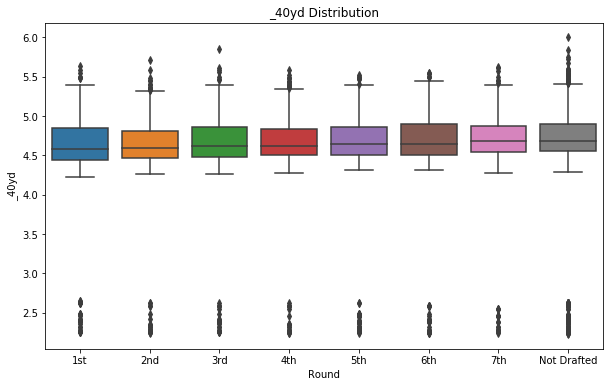

Vertical Summary:
count   5492.00
mean      29.34
std        7.99
min       11.75
25%       24.50
50%       32.00
75%       35.00
max       46.00
Name: Vertical, dtype: float64
----------------------------------------
Vertical by Round
             Vertical
Round                
1st             29.22
2nd             30.34
3rd             29.91
4th             30.19
5th             29.78
6th             29.26
7th             29.54
Not Drafted     28.40


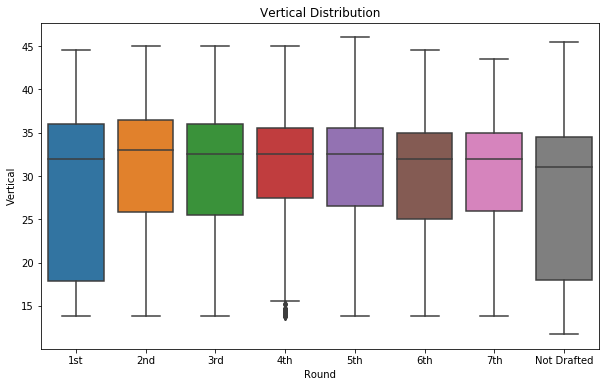

Bench Summary:
count   5492.00
mean      16.70
std        7.42
min        2.00
25%        9.70
50%       16.00
75%       22.00
max       49.00
Name: Bench, dtype: float64
----------------------------------------
Bench by Round
             Bench
Round             
1st          17.45
2nd          17.67
3rd          17.57
4th          17.48
5th          17.50
6th          16.74
7th          17.29
Not Drafted  15.15


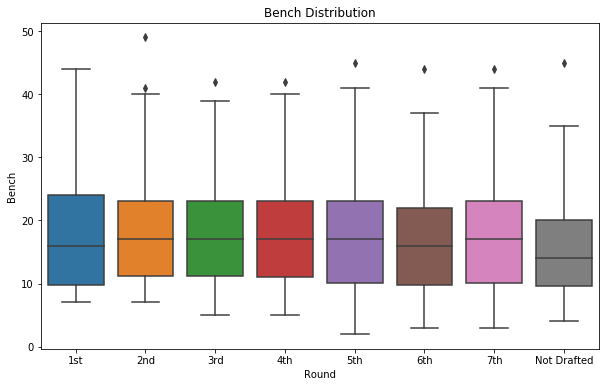

BroadJump Summary:
count   5492.00
mean     101.48
std       26.08
min       50.14
25%       93.00
50%      113.00
75%      120.00
max      147.00
Name: BroadJump, dtype: float64
----------------------------------------
BroadJump by Round
             BroadJump
Round                 
1st             100.23
2nd             103.65
3rd             103.07
4th             103.49
5th             103.23
6th             101.98
7th             101.30
Not Drafted      99.37


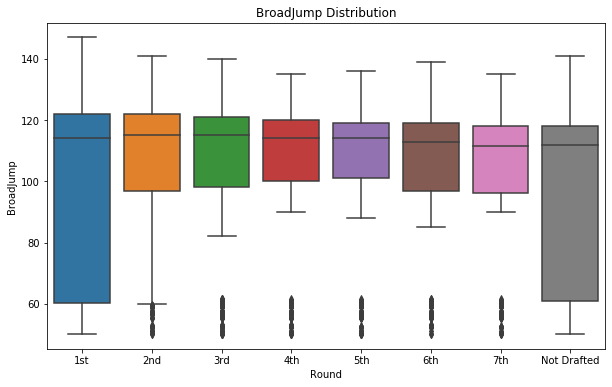

_3Cone Summary:
count   5492.00
mean       5.75
std        1.91
min        0.00
25%        3.58
50%        6.90
75%        7.22
max        9.04
Name: _3Cone, dtype: float64
----------------------------------------
_3Cone by Round
             _3Cone
Round              
1st            5.58
2nd            5.81
3rd            5.92
4th            5.90
5th            5.80
6th            5.93
7th            5.93
Not Drafted    5.57


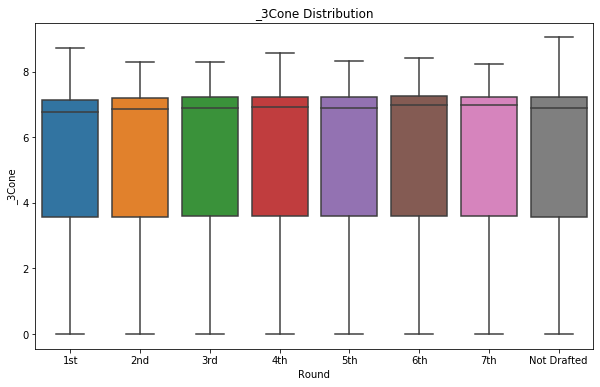

Shuttle Summary:
count   5492.00
mean       3.50
std        1.15
min        0.00
25%        2.16
50%        4.15
75%        4.38
max        5.56
Name: Shuttle, dtype: float64
----------------------------------------
Shuttle by Round
             Shuttle
Round               
1st             3.41
2nd             3.53
3rd             3.59
4th             3.60
5th             3.53
6th             3.58
7th             3.58
Not Drafted     3.42


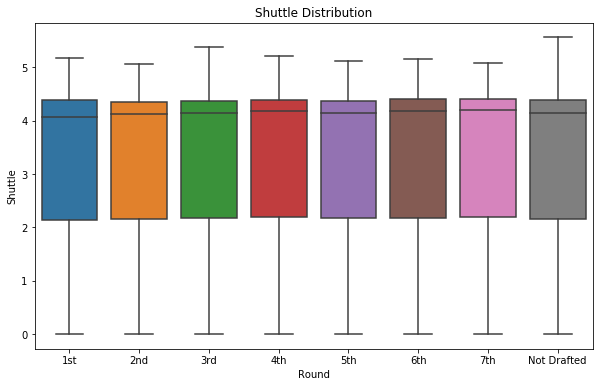

In [63]:
plot_stats_box(df, combine_stats)

From the graphs, it doesn't look like the combine results will be super telling for predicting draft rounds. I'll test each using an ANOVA & Tukey-MC comparison test. 

#### 40yd Dash

H0: The average 40yd dash is the same among the different draft picks.

H1: The average 40yd dash is not the same among the different draft picks.

#### Vertical

H0: The average vertical is the same among the different draft picks.

H1: The average vertical is not the same among the different draft picks.

#### Bench Press

H0: The average bench press is the same among the different draft picks.

H1: The average bench press is not the same among the different draft picks.

#### Broad Jump

H0: The average broad jump is the same among the different draft picks.

H1: The average broad jump is not the same among the different draft picks.

#### 3 cone

H0: The average 3 cone is the same among the different draft picks.

H1: The average 3 cone is not the same among the different draft picks.

#### Shuttle

H0: The average shuttle is the same among the different draft picks.

H1: The average shuttle is not the same among the different draft picks.

In [43]:
for i in combine_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df, i)
    print('')
    print('*' * 60)

_40yd ANOVA Test:
----------------------------------------
              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    2.85     0.41 1.20    0.30
Residual 5484.00 1857.63     0.34  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0048    0.9 -0.1082 0.0985  False
   1st         3rd    0.037    0.9 -0.0641 0.1381  False
   1st         4th   0.0439 0.8965 -0.0577 0.1455  False
   1st         5th  -0.0098    0.9 -0.1152 0.0955  False
   1st         6th   0.0269    0.9 -0.0833 0.1371  False
   1st         7th   0.0734 0.4799 -0.0376 0.1844  False
   1st Not Drafted   0.0297    0.9 -0.0532 0.1126  False
   2nd         3rd   0.0418    0.9 -0.0618 0.1454  False
   2nd         4th   0.0487 0.8315 -0.0554 0.1528  False
   2nd         5th   -0.005    0.9 -0.1128 0.1028  False
   2nd         6th   0.0317    0.9 -0.0808 0.1443  False
 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   0.1214 0.6001 -0.0825  0.3254  False
   1st         3rd   0.1859 0.0888 -0.0136  0.3853  False
   1st         4th   0.1875 0.0867 -0.0129   0.388  False
   1st         5th   0.1241  0.598 -0.0839   0.332  False
   1st         6th   0.1731 0.2348 -0.0443  0.3905  False
   1st         7th     0.17 0.2651  -0.049   0.389  False
   1st Not Drafted   0.0132    0.9 -0.1505  0.1768  False
   2nd         3rd   0.0644    0.9 -0.1401  0.2689  False
   2nd         4th   0.0661    0.9 -0.1394  0.2716  False
   2nd         5th   0.0026    0.9 -0.2101  0.2154  False
   2nd         6th   0.0516    0.9 -0.1704  0.2737  False
   2nd         7th   0.0486    0.9 -0.1751  0.2722  False
   2nd Not Drafted  -0.1083 0.5229  -0.278  0.0614  False
   3rd         4th   0.0017    0.9 -0.1994  0.2027  False
   3rd        

Interesting enough, the 40 yd dash seems to hold no bearing on predicting Round picks. All other combine perfomance statistics does in fact differ among the picks so I'll include those in my features.

### College Stats - Passing

I want to look at the college stats like I did for the combine results. I split these features up based on the overarching theme - ie Passing, Rushing, Defense, Kicking, Punt Returning and Scoring. First up is Passing.

In [49]:
passing_stats = ['Passing_Games', 'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                 'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 'Pass_Interceptions', 'Passer_Rating', 
                 'CompletionsperGame', 'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                 'Pass_InterceptionsperGame']

In [50]:
df[passing_stats].describe()

,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,1.92,14.95,23.99,6.72,190.28,1.06,1.14,1.49,0.59,19.71,1.22,1.96,15.52,0.12,0.05
std,4.44,60.99,96.53,21.13,770.39,4.27,6.01,6.20,2.44,77.57,4.91,7.82,61.94,0.50,0.20
min,0.00,0.00,0.00,0.00,-9.00,-9.00,-45.00,0.00,0.00,-200.00,0.00,0.00,-0.64,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,493.00,719.00,100.00,5833.00,81.00,101.00,60.00,22.00,1110.40,39.33,58.44,448.69,4.00,1.70


There are a ton of features currently listed, so I want limit this in some capacity. I don't think Games has any bearing on draft rounds, so I want to exclude that. I added a ton of features to be by game. I want to use those that make sense along with the ratings I've already brought in. I updated the passing_stats list below before I pass it through my plotting function & ANOVA test function.

In [66]:
passing_stats = ['Completions', 'Completion_Percent', 'Pass_Yards', 'Pass_TDs', 'Passer_Rating', 
                 'CompletionsperGame', 'Pass_YardsperGame']

Now I can view these stats. The shortened list makes it a lot easier to interpret these metrics.

Completions Summary:
count   5492.00
mean      14.95
std       60.99
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      493.00
Name: Completions, dtype: float64
----------------------------------------
Completions by Round
             Round      
Completions  1st           25.93
             2nd            9.21
             3rd           10.89
             4th           11.45
             5th           10.65
             6th           19.71
             7th           14.90
             Not Drafted   15.60
dtype: float64


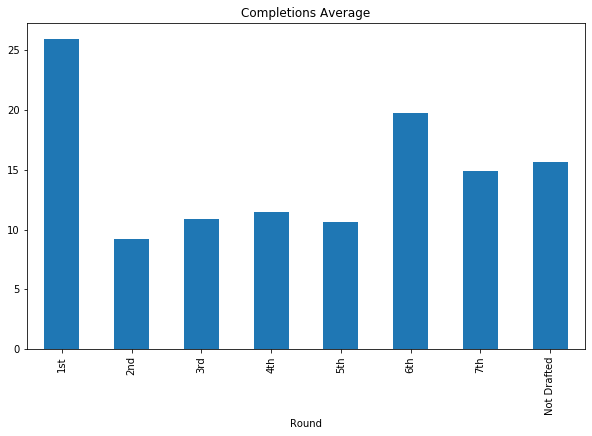

Completion_Percent Summary:
count   5492.00
mean       6.72
std       21.13
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: Completion_Percent, dtype: float64
----------------------------------------
Completion_Percent by Round
                    Round      
Completion_Percent  1st           8.95
                    2nd           4.92
                    3rd           5.94
                    4th           5.05
                    5th           6.30
                    6th           6.75
                    7th           6.48
                    Not Drafted   7.52
dtype: float64


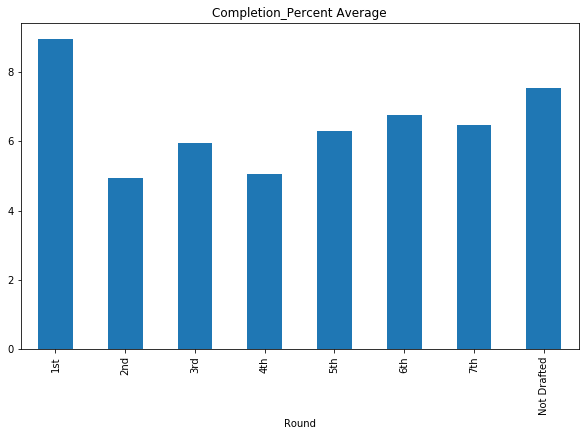

Pass_Yards Summary:
count   5492.00
mean     190.28
std      770.39
min       -9.00
25%        0.00
50%        0.00
75%        0.00
max     5833.00
Name: Pass_Yards, dtype: float64
----------------------------------------
Pass_Yards by Round
            Round      
Pass_Yards  1st           339.32
            2nd           117.18
            3rd           135.03
            4th           147.82
            5th           136.78
            6th           245.01
            7th           193.17
            Not Drafted   196.19
dtype: float64


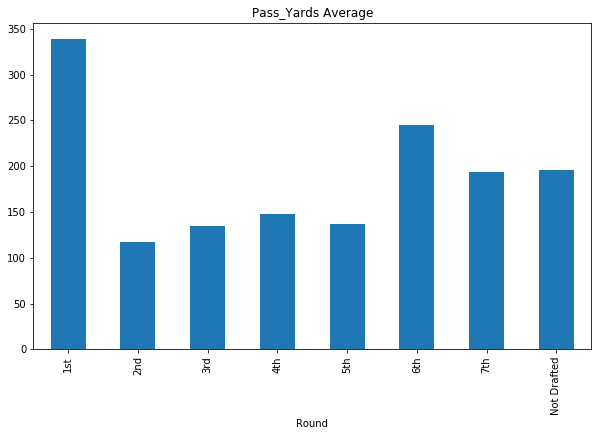

Pass_TDs Summary:
count   5492.00
mean       1.49
std        6.20
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       60.00
Name: Pass_TDs, dtype: float64
----------------------------------------
Pass_TDs by Round
          Round      
Pass_TDs  1st           2.86
          2nd           0.95
          3rd           1.01
          4th           1.03
          5th           1.11
          6th           1.96
          7th           1.48
          Not Drafted   1.52
dtype: float64


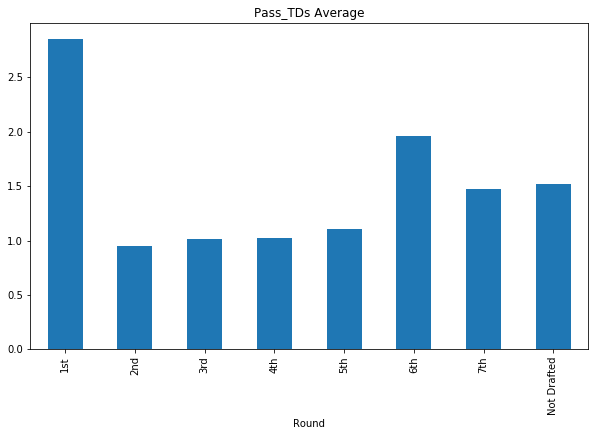

Passer_Rating Summary:
count   5492.00
mean      19.71
std       77.57
min     -200.00
25%        0.00
50%        0.00
75%        0.00
max     1110.40
Name: Passer_Rating, dtype: float64
----------------------------------------
Passer_Rating by Round
               Round      
Passer_Rating  1st           26.66
               2nd           15.37
               3rd           17.69
               4th           16.85
               5th           17.10
               6th           16.45
               7th           20.00
               Not Drafted   21.87
dtype: float64


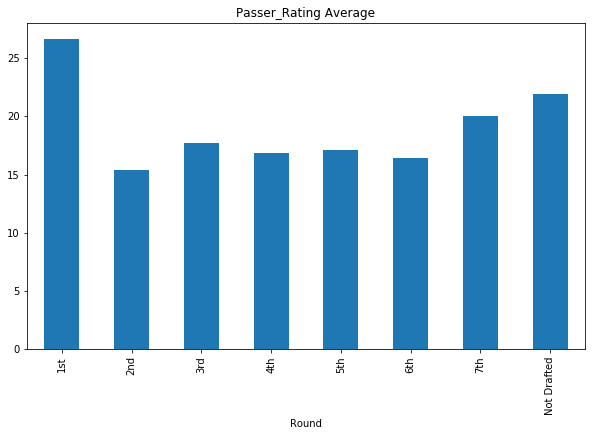

CompletionsperGame Summary:
count   5492.00
mean       1.22
std        4.91
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       39.33
Name: CompletionsperGame, dtype: float64
----------------------------------------
CompletionsperGame by Round
                    Round      
CompletionsperGame  1st           2.04
                    2nd           0.77
                    3rd           0.90
                    4th           0.95
                    5th           0.88
                    6th           1.61
                    7th           1.19
                    Not Drafted   1.29
dtype: float64


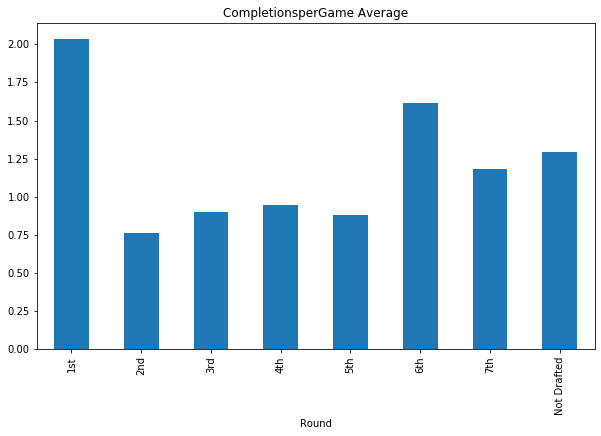

Pass_YardsperGame Summary:
count   5492.00
mean      15.52
std       61.94
min       -0.64
25%        0.00
50%        0.00
75%        0.00
max      448.69
Name: Pass_YardsperGame, dtype: float64
----------------------------------------
Pass_YardsperGame by Round
                   Round      
Pass_YardsperGame  1st           26.65
                   2nd            9.73
                   3rd           11.11
                   4th           12.23
                   5th           11.36
                   6th           20.12
                   7th           15.34
                   Not Drafted   16.21
dtype: float64


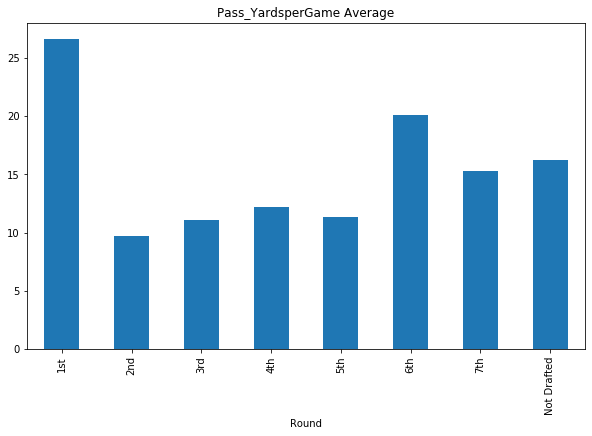

In [115]:
plot_stats_bar(df, passing_stats)

### Hypothesis Testing

####  Completions

H0: The average number of completions is the same among the different draft picks.

H1: The average number of completions is not the same among the different draft picks.


####  Completion Percent

H0: The average completion percent is the same among the different draft picks.

H1: The average completion percent is not the same among the different draft picks.


#### Pass Yards

H0: The average passing yards is the same among the different draft picks.

H1: The average passing yards is not the same among the different draft picks.


#### Pass TDs

H0: The average number of pass TDs is the same among the different draft picks.

H1: The average number of pass TDs is not the same among the different draft picks.


#### Passer Rating

H0: The average passer rating is the same among the different draft picks.

H1: The average passer rating is not the same among the different draft picks.


####  Completions per Game

H0: The average number of completions per game is the same among the different draft picks.

H1: The average number of completions per game is not the same among the different draft picks.


#### Pass Yards

H0: The average passing yards per game is the same among the different draft picks.

H1: The average passing yards per game is not the same among the different draft picks.

In [123]:
for i in passing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df, i)
    print('')
    print('*' * 40)

Completions ANOVA Test:
----------------------------------------
              df      sum_sq  mean_sq    F  PR(>F)
Round       7.00   129740.27 18534.32 5.01    0.00
Residual 5484.00 20298780.00  3701.46  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd -16.7176  0.001  -27.521 -5.9142   True
   1st         3rd -15.0421  0.001 -25.6092  -4.475   True
   1st         4th  -14.482  0.001 -25.1027 -3.8614   True
   1st         5th -15.2761  0.001 -26.2911 -4.2611   True
   1st         6th  -6.2246 0.6998  -17.743  5.2937  False
   1st         7th -11.0299 0.0767 -22.6336  0.5739  False
   1st Not Drafted -10.3299 0.0074 -18.9973 -1.6624   True
   2nd         3rd   1.6756    0.9  -9.1575 12.5086  False
   2nd         4th   2.2356    0.9  -8.6497 13.1208  False
   2nd         5th   1.4415    0.9  -9.8288 12.7119  False
   2nd        

              df    sum_sq  mean_sq    F  PR(>F)
Round       7.00    768.65   109.81 4.57    0.00
Residual 5484.00 131761.79    24.03  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -1.2709  0.001 -2.1413 -0.4005   True
   1st         3rd  -1.1375 0.0013 -1.9889 -0.2861   True
   1st         4th  -1.0907 0.0028 -1.9464 -0.2351   True
   1st         5th  -1.1571  0.002 -2.0445 -0.2696   True
   1st         6th  -0.4217 0.8556 -1.3497  0.5063  False
   1st         7th  -0.8515 0.1051 -1.7864  0.0834  False
   1st Not Drafted  -0.7451 0.0269 -1.4434 -0.0468   True
   2nd         3rd   0.1334    0.9 -0.7394  1.0061  False
   2nd         4th   0.1801    0.9 -0.6969  1.0571  False
   2nd         5th   0.1138    0.9 -0.7942  1.0218  False
   2nd         6th   0.8491  0.118 -0.0986  1.7968  False
   2nd         7th   0.4193 0.8829 -0.53

For the most part, I am able to reject the null hypothesis and I'll want to include them in my model. Passer Rating doesn't appear to matter between rounds.

### College Stats - Rushing & Receiving

In [124]:
rushing_stats = ['Rush_Rec_Games', 'Rush_Attempts', 'Rush_Yds', 'Rush_Yds_per_Attempt', 'Rush_TDs', 
                 'Receptions', 'Rec_Yds', 'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 'Scrimmage_Yds',
                 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs', 'Rush_AttemptsperGame', 'Rush_YdsperGame', 
                 'Rush_TDsperGame', 'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                 'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame', 'Scrimmage_TDsperGame']

In [125]:
df[rushing_stats].describe()

,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,2.70,25.63,122.71,0.87,1.37,2.31,21.68,1.20,0.13,27.95,144.38,0.94,1.51,2.17,10.40,0.12,0.20,1.84,0.01,2.37,12.23,0.13
std,5.05,67.33,363.94,2.98,3.93,7.92,78.72,3.70,0.62,73.13,420.16,3.11,4.26,5.62,30.27,0.33,0.66,6.53,0.05,6.10,34.95,0.35
min,0.00,0.00,-306.00,-16.00,0.00,0.00,-16.00,-16.00,0.00,0.00,-306.00,-16.00,0.00,0.00,-25.50,0.00,0.00,-1.23,0.00,0.00,-25.50,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,450.00,2587.00,57.00,31.00,98.00,1017.00,63.00,11.00,474.00,2809.00,57.00,32.00,33.55,196.18,3.00,8.36,78.83,0.79,34.45,200.75,3.00


Like passing stats, I want to shorten the list of statistics I'm looking at for rushing. Rushing encompasses Rushing & Receiving so there will be a number of features I want to look through here.

In [127]:
rushing_stats = ['Rush_Yds', 'Rush_Yds_per_Attempt', 'Rush_TDs', 'Receptions', 'Rec_Yds', 'Rec_TDs', 
                 'Plays_from_Scrimmage']

Rush_Yds Summary:
count   5492.00
mean     122.71
std      363.94
min     -306.00
25%        0.00
50%        0.00
75%        0.00
max     2587.00
Name: Rush_Yds, dtype: float64
----------------------------------------
Rush_Yds by Round
          Round      
Rush_Yds  1st           147.80
          2nd           142.59
          3rd           113.47
          4th           135.94
          5th           104.08
          6th           109.47
          7th           118.07
          Not Drafted   116.23
dtype: float64


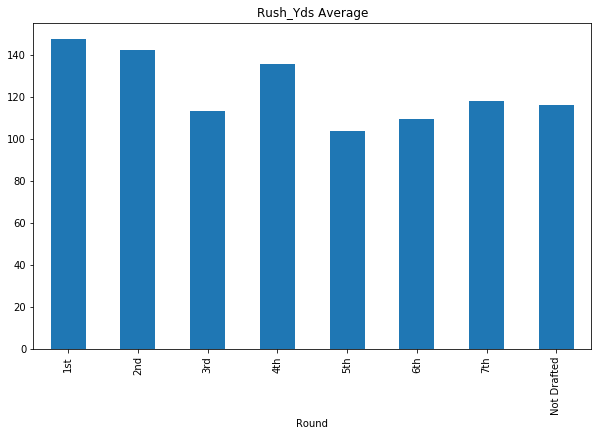

Rush_Yds_per_Attempt Summary:
count   5492.00
mean       0.87
std        2.98
min      -16.00
25%        0.00
50%        0.00
75%        0.00
max       57.00
Name: Rush_Yds_per_Attempt, dtype: float64
----------------------------------------
Rush_Yds_per_Attempt by Round
                      Round      
Rush_Yds_per_Attempt  1st           0.95
                      2nd           0.89
                      3rd           0.59
                      4th           1.01
                      5th           0.84
                      6th           0.73
                      7th           0.86
                      Not Drafted   0.92
dtype: float64


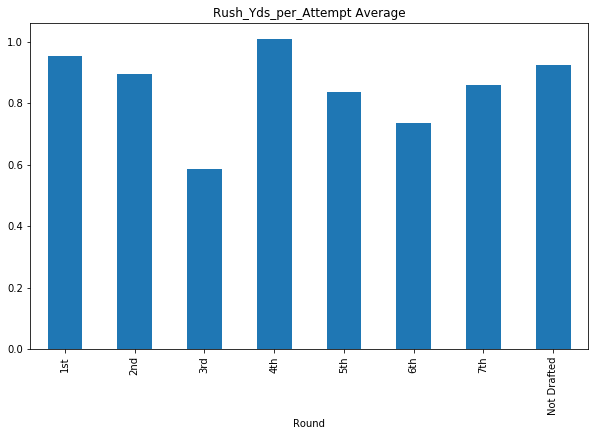

Rush_TDs Summary:
count   5492.00
mean       1.37
std        3.93
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       31.00
Name: Rush_TDs, dtype: float64
----------------------------------------
Rush_TDs by Round
          Round      
Rush_TDs  1st           1.77
          2nd           1.62
          3rd           1.30
          4th           1.44
          5th           1.14
          6th           1.28
          7th           1.20
          Not Drafted   1.30
dtype: float64


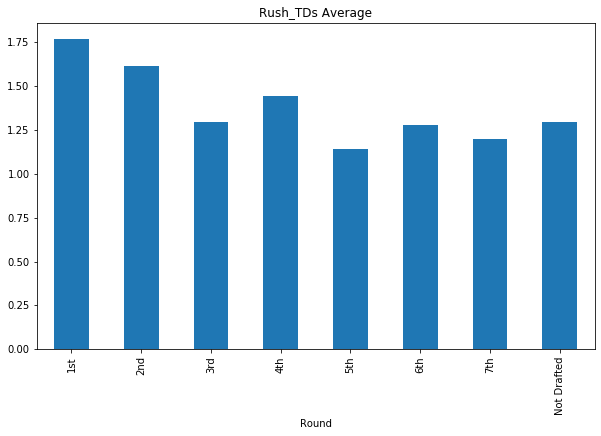

Receptions Summary:
count   5492.00
mean       2.31
std        7.92
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       98.00
Name: Receptions, dtype: float64
----------------------------------------
Receptions by Round
            Round      
Receptions  1st           2.01
            2nd           2.44
            3rd           2.00
            4th           2.60
            5th           1.93
            6th           2.21
            7th           2.50
            Not Drafted   2.48
dtype: float64


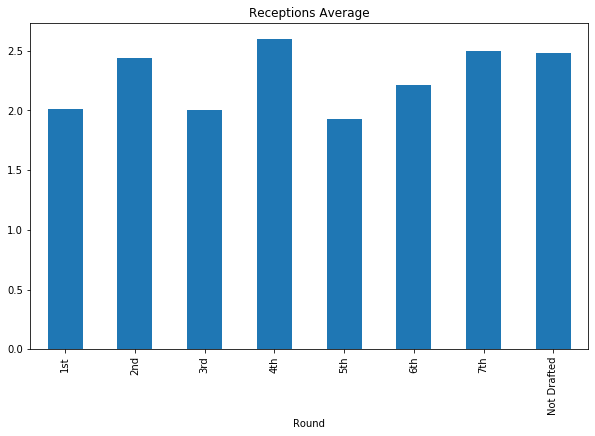

Rec_Yds Summary:
count   5492.00
mean      21.68
std       78.72
min      -16.00
25%        0.00
50%        0.00
75%        0.00
max     1017.00
Name: Rec_Yds, dtype: float64
----------------------------------------
Rec_Yds by Round
         Round      
Rec_Yds  1st           20.36
         2nd           25.04
         3rd           20.81
         4th           23.36
         5th           18.65
         6th           20.10
         7th           23.10
         Not Drafted   21.74
dtype: float64


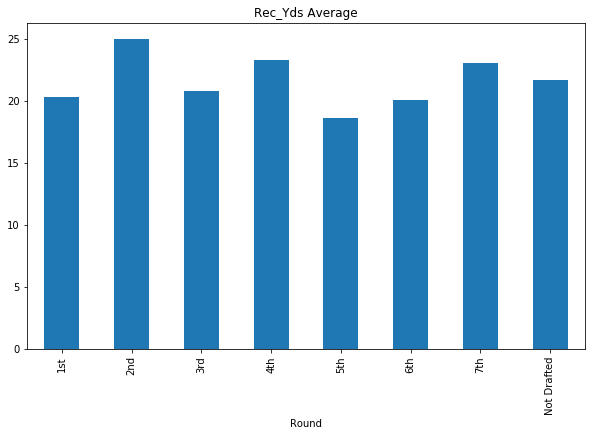

Rec_TDs Summary:
count   5492.00
mean       0.13
std        0.62
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       11.00
Name: Rec_TDs, dtype: float64
----------------------------------------
Rec_TDs by Round
         Round      
Rec_TDs  1st           0.15
         2nd           0.17
         3rd           0.12
         4th           0.15
         5th           0.10
         6th           0.13
         7th           0.16
         Not Drafted   0.12
dtype: float64


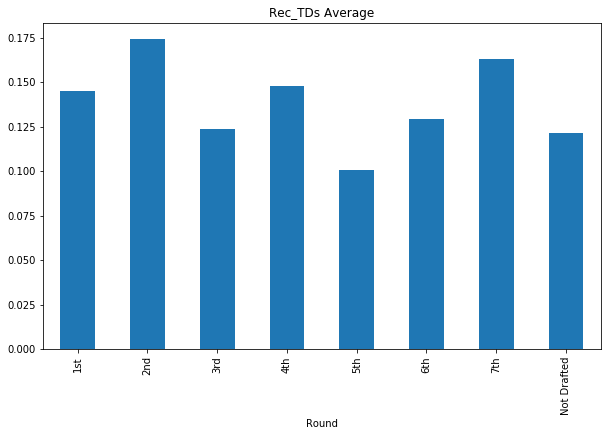

Plays_from_Scrimmage Summary:
count   5492.00
mean      27.95
std       73.13
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      474.00
Name: Plays_from_Scrimmage, dtype: float64
----------------------------------------
Plays_from_Scrimmage by Round
                      Round      
Plays_from_Scrimmage  1st           30.94
                      2nd           29.29
                      3rd           25.05
                      4th           30.08
                      5th           23.03
                      6th           26.60
                      7th           27.52
                      Not Drafted   28.65
dtype: float64


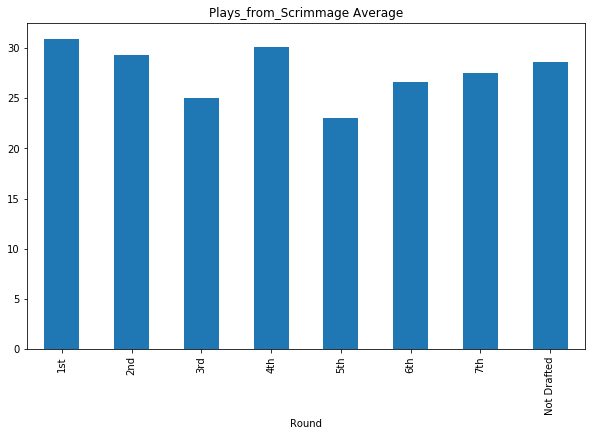

In [128]:
plot_stats_bar(df, rushing_stats)

### Hypothesis Testing

#### Rush Yards
H0: The average rushing yards is the same among the different draft picks.

H1: The average rushing yards is not the same among the different draft picks.


#### Rush Yards per Attempt
H0: The average rushing yards per attempt is the same among the different draft picks.

H1: The average rushing yards per attempt is not the same among the different draft picks.


#### Rush TDs
H0: The average number of rushing touchdowns is the same among the different draft picks.

H1: The average number of rushing touchdowns is not the same among the different draft picks.


#### Receptions
H0: The average number of receptions is the same among the different draft picks.

H1: The average number of receptions is not the same among the different draft picks.


#### Recption Yards per Attempt
H0: The average reception yards per attempt is the same among the different draft picks.

H1: The average reception yards per attempt is not the same among the different draft picks.


#### Reception TDs
H0: The average number of reception touchdowns is the same among the different draft picks.

H1: The average number of reception touchdowns is not the same among the different draft picks.


#### Plays from Scrimmage
H0: The average number of plays from scrimamge is the same among the different draft picks.

H1: The average number of plays from scrimmage is not the same among the different draft picks.

In [130]:
for i in rushing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df, i)
    print('')
    print('*' * 40)

Rush_Yds ANOVA Test:
----------------------------------------
              df       sum_sq   mean_sq    F  PR(>F)
Round       7.00   1100370.16 157195.74 1.19    0.31
Residual 5484.00 726175523.93 132417.13  nan     nan

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj    lower    upper  reject
-----------------------------------------------------------
   1st         2nd  -5.2093    0.9  -69.8261 59.4076  False
   1st         3rd  -34.329 0.6949  -97.5326 28.8746  False
   1st         4th -11.8633    0.9  -75.3871 51.6605  False
   1st         5th -43.7255  0.475 -109.6081  22.157  False
   1st         6th -38.3339 0.6708 -107.2272 30.5595  False
   1st         7th -29.7359    0.9  -99.1398 39.6681  False
   1st Not Drafted -31.5722 0.5755  -83.4134 20.2691  False
   2nd         3rd -29.1198 0.8647  -93.9139 35.6744  False
   2nd         4th   -6.654    0.9  -71.7606 58.4525  False
   2nd         5th -38.5163 0.6437 -105.9262 28.8936  Fals

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0293    0.9 -0.0802 0.1388  False
   1st         3rd  -0.0214    0.9 -0.1285 0.0857  False
   1st         4th    0.003    0.9 -0.1047 0.1106  False
   1st         5th  -0.0446    0.9 -0.1562  0.067  False
   1st         6th  -0.0159    0.9 -0.1327 0.1008  False
   1st         7th   0.0176    0.9    -0.1 0.1352  False
   1st Not Drafted  -0.0236    0.9 -0.1114 0.0643  False
   2nd         3rd  -0.0507 0.8423 -0.1605 0.0591  False
   2nd         4th  -0.0263    0.9 -0.1366  0.084  False
   2nd         5th  -0.0739 0.5071 -0.1881 0.0403  False
   2nd         6th  -0.0452    0.9 -0.1644  0.074  False
   2nd         7th  -0.0117    0.9 -0.1317 0.1084  False
   2nd Not Drafted  -0.0528 0.6281  -0.144 0.0383  False
   3rd         4th   0.0244    0.9 -0.0836 0.1323  False
   3rd         5th  -0.0232    

Again, I fail to reject the null hypothesis and I will exclude these rushing statistics from my model.

### College Stats - Defense

In [131]:
defense_stats = ['Defense_Games', 'Solo_Tackles', 'Assisted_Tackles', 'Ttl_Tackles', 'Loss', 'Sacks', 
                 'Defensive_Interceptions', 'Def_Int_Yds', 'Yds_per_Int', 'Pick_6', 'Defended_Passes', 
                 'Recovered_Fumbles', 'Rec_Fumbles_Yds', 'Fumbles_Returned_TD', 'Forced_Fumbles', 
                 'Solo_TacklesperGame', 'Assisted_TacklesperGame', 'Ttl_TacklesperGame', 'LossperGame', 
                 'SacksperGame', 'Defensive_InterceptionsperGame', 'Def_Int_YdsperGame', 'Pick_6perGame', 
                 'Defended_PassesperGame', 'Recovered_FumblesperGame', 'Rec_Fumbles_YdsperGame', 
                 'Fumbles_Returned_TDperGame', 'Forced_FumblesperGame']

In [132]:
df[defense_stats].describe()

,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,9.00,13.60,9.07,22.67,2.74,1.12,0.62,8.83,3.93,0.07,0.92,0.13,1.06,0.04,0.27,inf,inf,inf,inf,inf,0.05,0.74,0.01,inf,inf,inf,inf,inf
std,5.40,19.86,14.64,33.29,4.89,2.52,1.32,24.66,10.30,0.30,2.33,0.44,7.72,0.20,0.77,nan,nan,nan,nan,nan,0.11,2.16,0.03,nan,nan,nan,nan,nan
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-10.00,-8.00,0.00,0.00,0.00,-4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-8.00,0.00,0.00,0.00,-0.36,0.00,0.00
25%,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,12.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,13.00,27.00,16.00,44.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.33,1.36,3.80,0.33,0.08,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,114.00,97.00,191.00,28.50,20.00,14.00,280.00,100.00,4.00,23.00,4.00,184.00,3.00,9.00,inf,inf,inf,inf,inf,1.25,36.50,0.40,inf,inf,inf,inf,inf


Now I added per Game metrics off to the right, but I have an issue where some of my observations don't have a number of games. I checked my function to make sure it scraped properly, but it's actually a problem, with my data. I'll have to drop these columns so they don't create a problem when I start running models.

In [133]:
defense_stats = ['Ttl_Tackles', 'Loss', 'Sacks', 'Defensive_Interceptions', 'Yds_per_Int', 'Pick_6', 
                 'Defended_Passes', 'Recovered_Fumbles', 'Forced_Fumbles']

Ttl_Tackles Summary:
count   5492.00
mean      22.67
std       33.29
min        0.00
25%        0.00
50%        1.00
75%       44.00
max      191.00
Name: Ttl_Tackles, dtype: float64
----------------------------------------
Ttl_Tackles by Round
             Round      
Ttl_Tackles  1st           23.77
             2nd           26.06
             3rd           25.77
             4th           24.06
             5th           25.33
             6th           21.06
             7th           20.60
             Not Drafted   19.77
dtype: float64


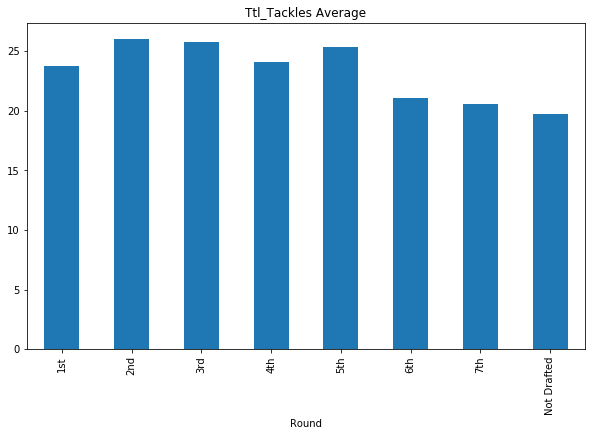

Loss Summary:
count   5492.00
mean       2.74
std        4.89
min        0.00
25%        0.00
50%        0.00
75%        4.00
max       28.50
Name: Loss, dtype: float64
----------------------------------------
Loss by Round
      Round      
Loss  1st           3.96
      2nd           3.35
      3rd           3.45
      4th           2.81
      5th           2.80
      6th           2.29
      7th           2.50
      Not Drafted   1.99
dtype: float64


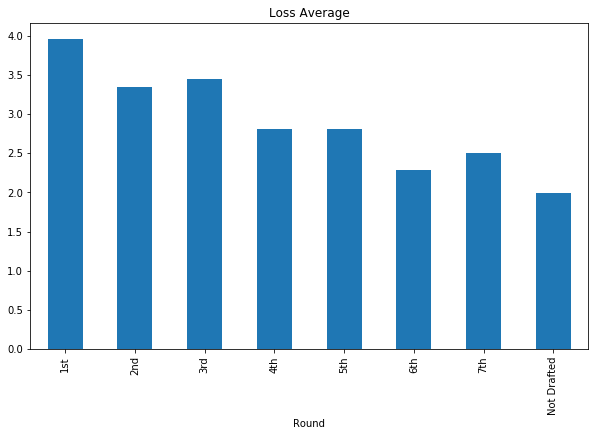

Sacks Summary:
count   5492.00
mean       1.12
std        2.52
min        0.00
25%        0.00
50%        0.00
75%        1.00
max       20.00
Name: Sacks, dtype: float64
----------------------------------------
Sacks by Round
       Round      
Sacks  1st           1.80
       2nd           1.47
       3rd           1.44
       4th           1.12
       5th           1.07
       6th           0.84
       7th           1.06
       Not Drafted   0.74
dtype: float64


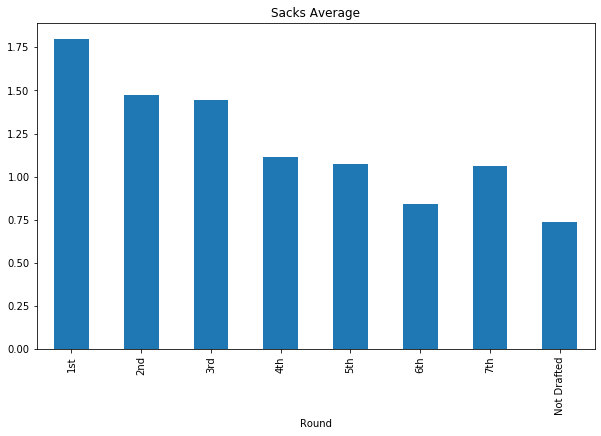

Defensive_Interceptions Summary:
count   5492.00
mean       0.62
std        1.32
min        0.00
25%        0.00
50%        0.00
75%        1.00
max       14.00
Name: Defensive_Interceptions, dtype: float64
----------------------------------------
Defensive_Interceptions by Round
                         Round      
Defensive_Interceptions  1st           0.65
                         2nd           0.90
                         3rd           0.68
                         4th           0.67
                         5th           0.71
                         6th           0.60
                         7th           0.45
                         Not Drafted   0.50
dtype: float64


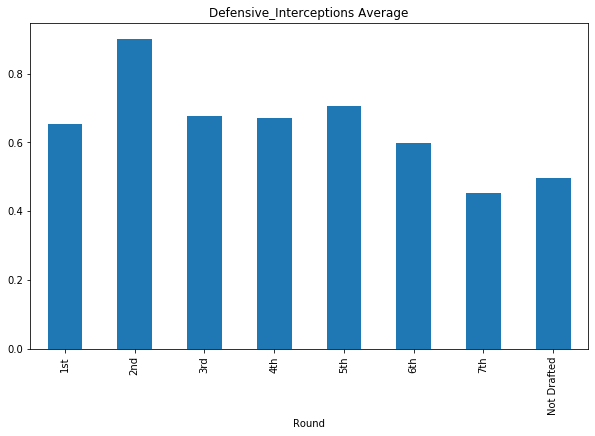

Yds_per_Int Summary:
count   5492.00
mean       3.93
std       10.30
min       -8.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: Yds_per_Int, dtype: float64
----------------------------------------
Yds_per_Int by Round
             Round      
Yds_per_Int  1st           4.15
             2nd           5.68
             3rd           4.12
             4th           3.76
             5th           4.58
             6th           3.29
             7th           3.39
             Not Drafted   3.38
dtype: float64


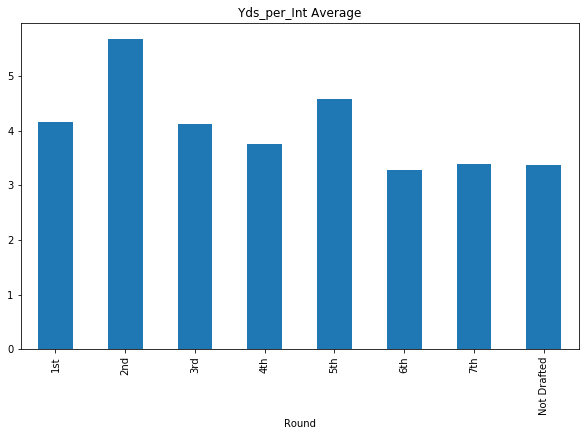

Pick_6 Summary:
count   5492.00
mean       0.07
std        0.30
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        4.00
Name: Pick_6, dtype: float64
----------------------------------------
Pick_6 by Round
        Round      
Pick_6  1st           0.10
        2nd           0.13
        3rd           0.08
        4th           0.08
        5th           0.09
        6th           0.05
        7th           0.06
        Not Drafted   0.05
dtype: float64


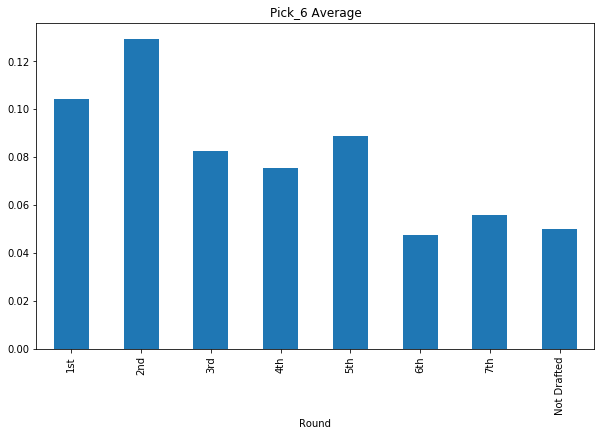

Defended_Passes Summary:
count   5492.00
mean       0.92
std        2.33
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       23.00
Name: Defended_Passes, dtype: float64
----------------------------------------
Defended_Passes by Round
                 Round      
Defended_Passes  1st           1.16
                 2nd           1.08
                 3rd           0.99
                 4th           1.06
                 5th           0.91
                 6th           0.80
                 7th           0.82
                 Not Drafted   0.77
dtype: float64


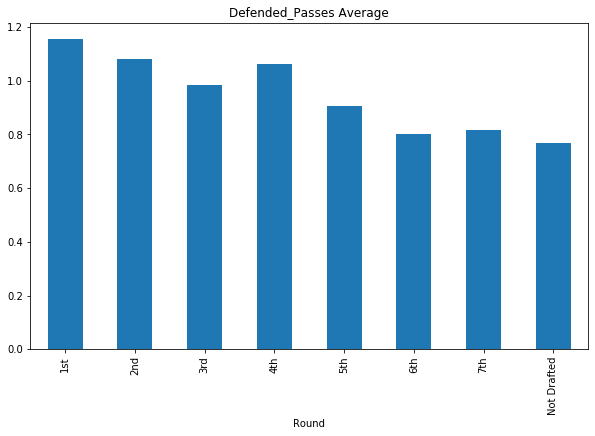

Recovered_Fumbles Summary:
count   5492.00
mean       0.13
std        0.44
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        4.00
Name: Recovered_Fumbles, dtype: float64
----------------------------------------
Recovered_Fumbles by Round
                   Round      
Recovered_Fumbles  1st           0.16
                   2nd           0.17
                   3rd           0.19
                   4th           0.13
                   5th           0.16
                   6th           0.12
                   7th           0.12
                   Not Drafted   0.10
dtype: float64


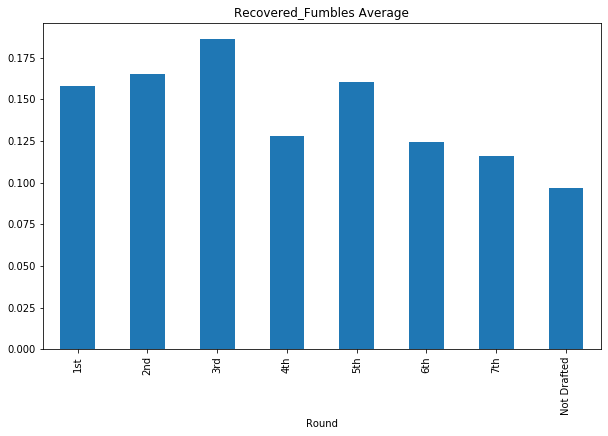

Forced_Fumbles Summary:
count   5492.00
mean       0.27
std        0.77
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        9.00
Name: Forced_Fumbles, dtype: float64
----------------------------------------
Forced_Fumbles by Round
                Round      
Forced_Fumbles  1st           0.38
                2nd           0.35
                3rd           0.31
                4th           0.26
                5th           0.28
                6th           0.24
                7th           0.27
                Not Drafted   0.19
dtype: float64


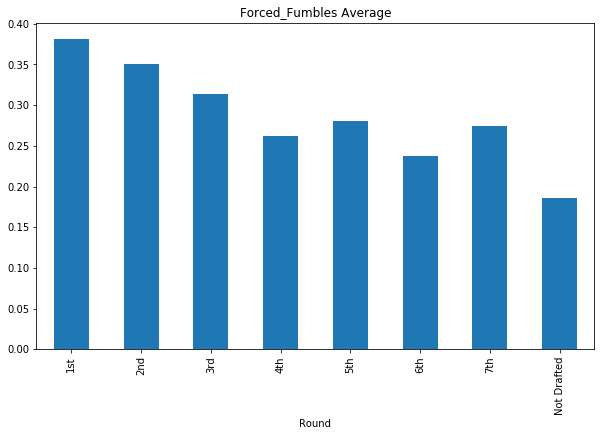

In [134]:
plot_stats_bar(df, defense_stats)

From these graphs, it starts to look like there is a difference between the rounds and the specific features I looked at. I'll run these through my hypothesis tests and see what does indeed make a difference.

### Hypothesis Tests

#### Total Tackles

H0: The average number of total tackles by players drafted are the same between rounds.

H1: The average number of total tackles by players drafted are not the same between rounds.


#### Tackles for a Loss

H0: The average number of tackles for a loss by players drafted are the same between rounds.

H1: The average number of tackles for a loss by players drafted are not the same between rounds.


#### Sacks

H0: The average number of sacks by players drafted are the same between rounds.

H1: The average number of sacks by players drafted are not the same between rounds.


#### Interceptions

H0: The average number of interceptions by players drafted are the same between rounds.

H1: The average number of interceptions by players drafted are not the same between rounds.



#### Interception Yards

H0: The average number of interception yards by players drafted are the same between rounds.

H1: The average number of interception yards by players drafted are not the same between rounds.


#### Yards per Interception

H0: The average number of yards per interception by players drafted are the same between rounds.

H1: The average number of yards per interception by players drafted are not the same between rounds.


#### Pick 6

H0: The average number of pick 6's by players drafted are the same between rounds.

H1: The average number of pick 6's by players drafted are not the same between rounds.


#### Defended Passes

H0: The average number of defended passes by players drafted are the same between rounds.

H1: The average number of defended passes by players drafted are not the same between rounds.


#### Recovered Fumbles

H0: The average number of recovered fumbles by players drafted are the same between rounds.

H1: The average number of recovered fumbles by players drafted are not the same between rounds.


#### Forced Fumbles

H0: The average number of forced fumbles by players drafted are the same between rounds.

H1: The average number of forced fumbles by players drafted are not the same between rounds.

In [136]:
for i in defense_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df, i)
    print('')
    print('*' * 40)

Ttl_Tackles ANOVA Test:
----------------------------------------
              df     sum_sq  mean_sq    F  PR(>F)
Round       7.00   35378.07  5054.01 4.58    0.00
Residual 5484.00 6050393.06  1103.28  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd   2.2894    0.9  -3.6088  8.1875  False
   1st         3rd    1.999    0.9  -3.7702  7.7682  False
   1st         4th    0.294    0.9  -5.5044  6.0924  False
   1st         5th   1.5627    0.9   -4.451  7.5764  False
   1st         6th   -2.711 0.8979  -8.9995  3.5775  False
   1st         7th  -3.1746  0.771  -9.5098  3.1605  False
   1st Not Drafted  -4.0023 0.1695  -8.7343  0.7298  False
   2nd         3rd  -0.2904    0.9  -6.2047   5.624  False
   2nd         4th  -1.9954    0.9  -7.9382  3.9475  False
   2nd         5th  -0.7267    0.9  -6.8798  5.4264  False
   2nd         6t

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   1.5302 0.1783 -0.2959  3.3563  False
   1st         3rd   -0.034    0.9 -1.8202  1.7521  False
   1st         4th  -0.3917    0.9 -2.1869  1.4035  False
   1st         5th   0.4253    0.9 -1.4366  2.2871  False
   1st         6th  -0.8668 0.8724 -2.8137  1.0802  False
   1st         7th  -0.7632    0.9 -2.7245  1.1982  False
   1st Not Drafted  -0.7763 0.7189 -2.2414  0.6887  False
   2nd         3rd  -1.5643 0.1596 -3.3954  0.2668  False
   2nd         4th   -1.922 0.0333 -3.7619  -0.082   True
   2nd         5th   -1.105  0.628   -3.01  0.8001  False
   2nd         6th   -2.397 0.0063 -4.3852 -0.4087   True
   2nd         7th  -2.2934 0.0122 -4.2958  -0.291   True
   2nd Not Drafted  -2.3065  0.001 -3.8261  -0.787   True
   3rd         4th  -0.3577    0.9  -2.158  1.4426  False
   3rd        

In all instances, I can reject the null hypothesis. These features will be important for my model.

### College Stats - Kicking

In [137]:
kicking_stats = ['Kicking_Games', 'XP_Made', 'XP_Attempts', 'XP_Percent', 'FG_Made', 'FG_Attempts', 'FG_Percent', 
                 'TTL_Kicking_Points', 'NumPunts', 'Punt_Yds', 'Yds_per_Punt', 'XP_MadeperGame', 'XP_AttemptsperGame',
                 'FG_MadeperGame', 'FG_AttemptsperGame', 'TTL_Kicking_PointsperGame', 'NumPuntsperGame', 
                 'Punt_YdsperGame']

In [138]:
df[kicking_stats].describe()

,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,0.21,0.63,0.64,1.53,0.29,0.37,1.21,1.49,0.16,6.58,0.20,0.05,0.05,0.02,0.03,0.12,0.01,0.55
std,1.60,5.33,5.44,12.14,2.40,3.03,9.74,12.30,2.87,120.54,2.84,0.42,0.43,0.19,0.24,0.98,0.23,9.88
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,87.00,88.00,100.00,30.00,35.00,95.20,156.00,81.00,3259.00,48.10,6.21,6.29,2.42,2.92,12.00,6.23,271.58


In [139]:
kicking_stats = ['XP_Made', 'XP_Percent', 'FG_Made', 'FG_Percent', 'TTL_Kicking_Points', 'NumPunts', 'Yds_per_Punt']

XP_Made Summary:
count   5492.00
mean       0.63
std        5.33
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       87.00
Name: XP_Made, dtype: float64
----------------------------------------
XP_Made by Round
         Round      
XP_Made  1st           0.08
         2nd           0.14
         3rd           0.07
         4th           0.20
         5th           0.89
         6th           0.68
         7th           0.45
         Not Drafted   1.27
dtype: float64


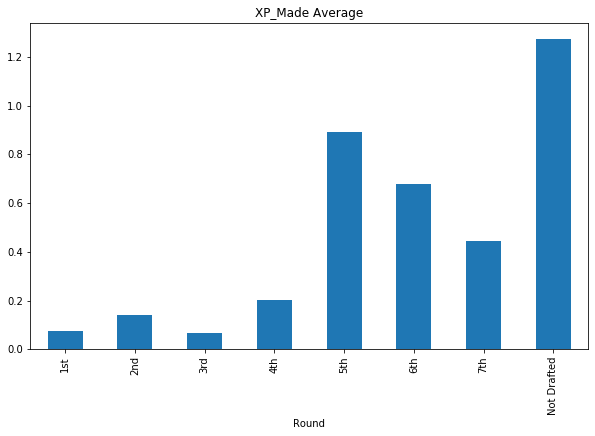

XP_Percent Summary:
count   5492.00
mean       1.53
std       12.14
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: XP_Percent, dtype: float64
----------------------------------------
XP_Percent by Round
            Round      
XP_Percent  1st           0.16
            2nd           0.36
            3rd           0.16
            4th           0.46
            5th           1.92
            6th           1.80
            7th           1.39
            Not Drafted   3.08
dtype: float64


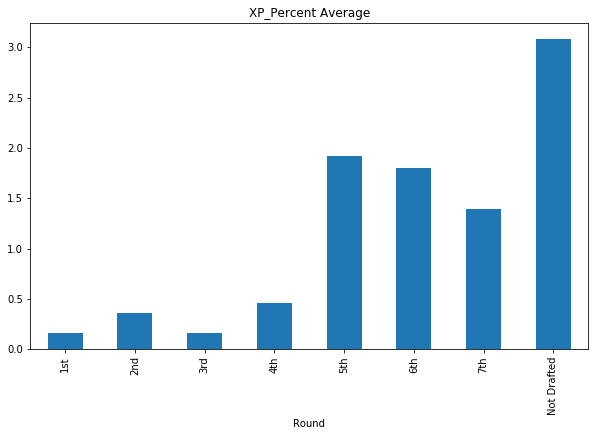

FG_Made Summary:
count   5492.00
mean       0.29
std        2.40
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       30.00
Name: FG_Made, dtype: float64
----------------------------------------
FG_Made by Round
         Round      
FG_Made  1st           0.04
         2nd           0.08
         3rd           0.03
         4th           0.10
         5th           0.38
         6th           0.39
         7th           0.20
         Not Drafted   0.56
dtype: float64


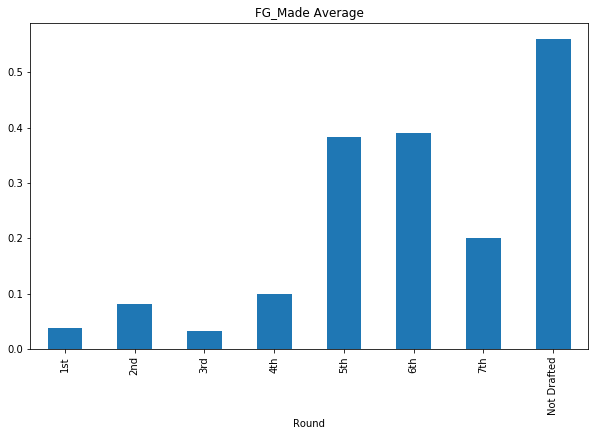

FG_Percent Summary:
count   5492.00
mean       1.21
std        9.74
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       95.20
Name: FG_Percent, dtype: float64
----------------------------------------
FG_Percent by Round
            Round      
FG_Percent  1st           0.13
            2nd           0.31
            3rd           0.16
            4th           0.44
            5th           1.41
            6th           1.35
            7th           1.08
            Not Drafted   2.45
dtype: float64


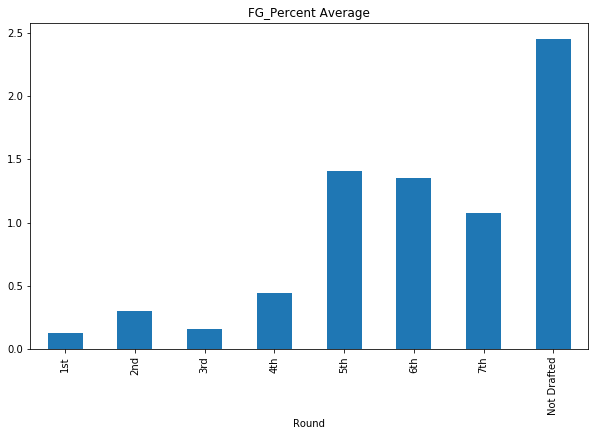

TTL_Kicking_Points Summary:
count   5492.00
mean       1.49
std       12.30
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      156.00
Name: TTL_Kicking_Points, dtype: float64
----------------------------------------
TTL_Kicking_Points by Round
                    Round      
TTL_Kicking_Points  1st           0.19
                    2nd           0.38
                    3rd           0.17
                    4th           0.50
                    5th           2.04
                    6th           1.85
                    7th           1.05
                    Not Drafted   2.96
dtype: float64


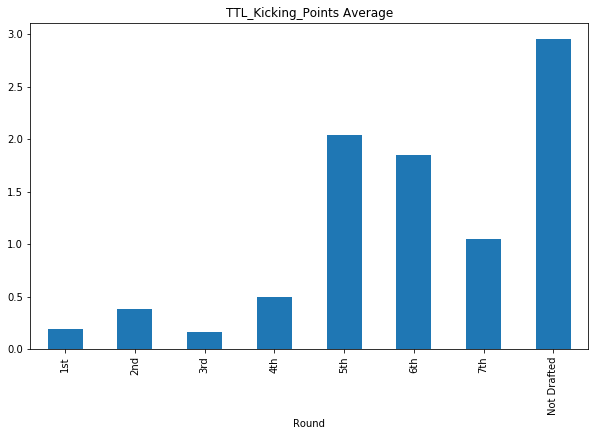

NumPunts Summary:
count   5492.00
mean       0.16
std        2.87
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       81.00
Name: NumPunts, dtype: float64
----------------------------------------
NumPunts by Round
          Round      
NumPunts  1st           0.00
          2nd           0.00
          3rd           0.00
          4th           0.21
          5th           0.06
          6th           0.18
          7th           0.00
          Not Drafted   0.37
dtype: float64


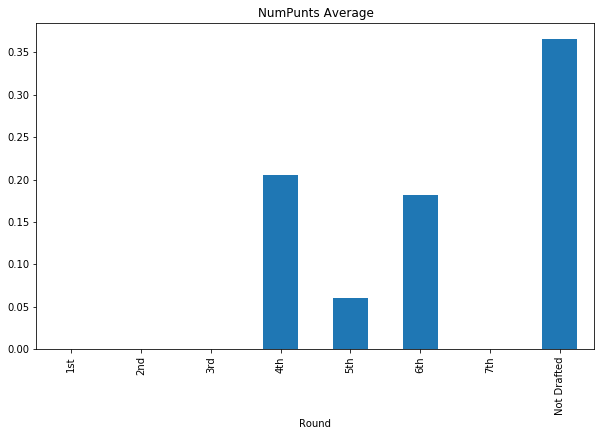

Yds_per_Punt Summary:
count   5492.00
mean       0.20
std        2.84
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       48.10
Name: Yds_per_Punt, dtype: float64
----------------------------------------
Yds_per_Punt by Round
              Round      
Yds_per_Punt  1st           0.00
              2nd           0.00
              3rd           0.00
              4th           0.15
              5th           0.08
              6th           0.28
              7th           0.00
              Not Drafted   0.49
dtype: float64


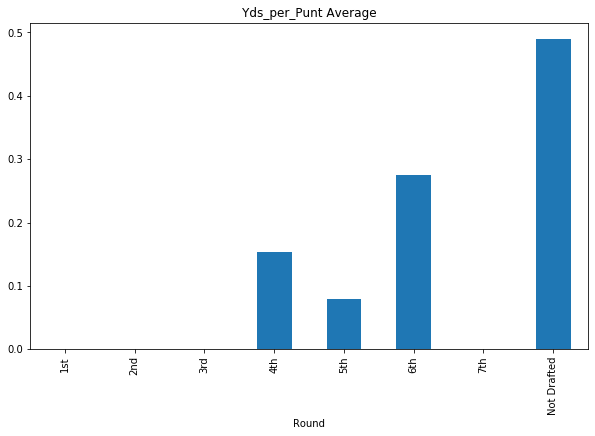

In [141]:
plot_stats_bar(df, kicking_stats)

Safe to say, kickers get no respect. Whether its the punter or the kicker, they usually have to wait to be drafted in later rounds. Safe to say, that'll help predict their round.

### Hypothesis Testing

#### Extra Points Made

H0: The average number of extra points made by players drafted are the same between rounds.

H1: The average number of extra points made by players drafted are not the same between rounds.


#### Extra Points Percent

H0: The average ratio of extra points made to attempts by players drafted are the same between rounds.

H1: The average ratio of extra points made to attempts by players drafted are not the same between rounds.


#### Field Goals Made

H0: The number of field goals made by players drafted are the same between rounds.

H1: The number of field goals made by players drafted are not the same between rounds.


#### Field Goals Percent

H0: The average ratio of field goals made to attempts by players drafted are the same between rounds.

H1: The average ratio of field goals made to attempts by players drafted are not the same between rounds.


#### Kicking Points

H0: The average number of kicking points by players drafted are the same between rounds.

H1: The average number of kicking points by players drafted are not the same between rounds.


#### Number of Punts

H0: The average number of punts by players drafted are the same between rounds.

H1: The average number of punts by players drafted are not the same between rounds.


#### Yards per Punt

H0: The average yards per punt by players drafted are the same between rounds.

H1: The average yards per punt by players drafted are not the same between rounds.

In [143]:
for i in kicking_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df, i)
    print('')
    print('*' * 40)

XP_Made ANOVA Test:
----------------------------------------
              df    sum_sq  mean_sq    F  PR(>F)
Round       7.00   1394.66   199.24 7.06    0.00
Residual 5484.00 154681.84    28.21  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0654    0.9 -0.8777 1.0085  False
   1st         3rd  -0.0107    0.9 -0.9331 0.9118  False
   1st         4th   0.1253    0.9 -0.8018 1.0525  False
   1st         5th   0.8169  0.165 -0.1446 1.7785  False
   1st         6th   0.6013 0.5954 -0.4042 1.6068  False
   1st         7th   0.3698    0.9 -0.6431 1.3828  False
   1st Not Drafted   1.1983  0.001  0.4416 1.9549   True
   2nd         3rd  -0.0761    0.9 -1.0217 0.8696  False
   2nd         4th   0.0599    0.9 -0.8903 1.0102  False
   2nd         5th   0.7515 0.2849 -0.2323 1.7354  False
   2nd         6th   0.5359 0.7333 -0.4909 1.5627 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -0.5086 0.5086  False
   1st         3rd      0.0    0.9 -0.4974 0.4974  False
   1st         4th   0.2054    0.9 -0.2946 0.7053  False
   1st         5th     0.06    0.9 -0.4586 0.5785  False
   1st         6th   0.1814    0.9 -0.3608 0.7236  False
   1st         7th      0.0    0.9 -0.5462 0.5462  False
   1st Not Drafted    0.366 0.1171  -0.042  0.774  False
   2nd         3rd      0.0    0.9 -0.5099 0.5099  False
   2nd         4th   0.2054    0.9  -0.307 0.7178  False
   2nd         5th     0.06    0.9 -0.4706 0.5905  False
   2nd         6th   0.1814    0.9 -0.3723 0.7351  False
   2nd         7th      0.0    0.9 -0.5577 0.5577  False
   2nd Not Drafted    0.366 0.1479 -0.0572 0.7892  False
   3rd         4th   0.2054    0.9  -0.296 0.7068  False
   3rd         5th     0.06    

Hitting extra points and field goals matter! With the exception of the number of punts kicked, all of these metrics reject the null hypothesis. As a Jets fan, I can attest to the fact that games are won on XP and field goals so we all need to revist what we think of as a top pick and find some kickers!

### College Stats - Punt Returns

In [144]:
puntret_stats = ['PuntRet_Games', 'Kickoff_Returns', 'KO_Return_Yds', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                 'Kickoff_ReturnsperGame', 'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame']

In [145]:
df[puntret_stats].describe()

,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,1.61,0.21,4.95,0.63,0.00,0.02,0.41,0.00
std,4.13,1.81,44.34,3.75,0.06,0.15,3.67,0.00
min,0.00,0.00,-8.00,-8.00,0.00,0.00,-0.89,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,33.00,845.00,41.00,2.00,2.75,65.00,0.17


Punt Returns are hard. They're very specific. There isn't an overwhelming amount of data in this section so I'm only going to focus on Kickoff Returns, Return Yards and Yards per Kickoff Return.

In [146]:
puntret_stats = ['Kickoff_Returns', 'KO_Return_Yds', 'Yds_per_KO_Return']

Kickoff_Returns Summary:
count   5492.00
mean       0.21
std        1.81
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       33.00
Name: Kickoff_Returns, dtype: float64
----------------------------------------
Kickoff_Returns by Round
                 Round      
Kickoff_Returns  1st           0.35
                 2nd           0.22
                 3rd           0.19
                 4th           0.27
                 5th           0.39
                 6th           0.23
                 7th           0.10
                 Not Drafted   0.12
dtype: float64


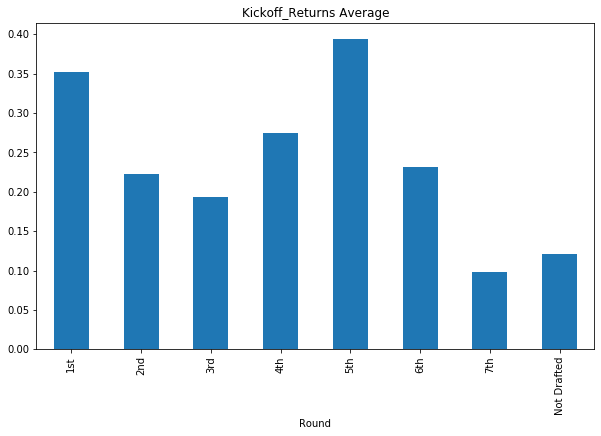

KO_Return_Yds Summary:
count   5492.00
mean       4.95
std       44.34
min       -8.00
25%        0.00
50%        0.00
75%        0.00
max      845.00
Name: KO_Return_Yds, dtype: float64
----------------------------------------
KO_Return_Yds by Round
               Round      
KO_Return_Yds  1st           8.38
               2nd           5.10
               3rd           4.47
               4th           6.40
               5th           8.69
               6th           5.83
               7th           2.43
               Not Drafted   2.64
dtype: float64


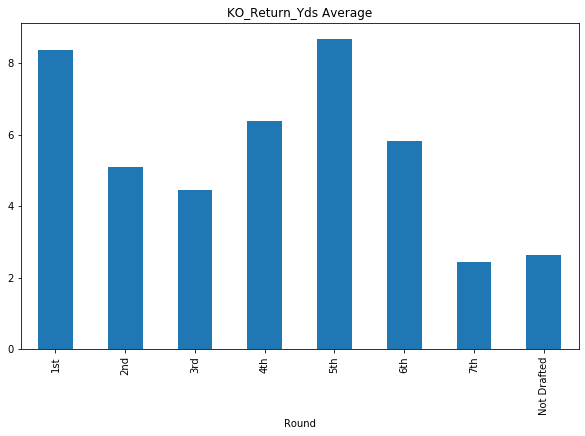

Yds_per_KO_Return Summary:
count   5492.00
mean       0.63
std        3.75
min       -8.00
25%        0.00
50%        0.00
75%        0.00
max       41.00
Name: Yds_per_KO_Return, dtype: float64
----------------------------------------
Yds_per_KO_Return by Round
                   Round      
Yds_per_KO_Return  1st           0.98
                   2nd           0.68
                   3rd           0.58
                   4th           0.76
                   5th           0.68
                   6th           0.64
                   7th           0.35
                   Not Drafted   0.50
dtype: float64


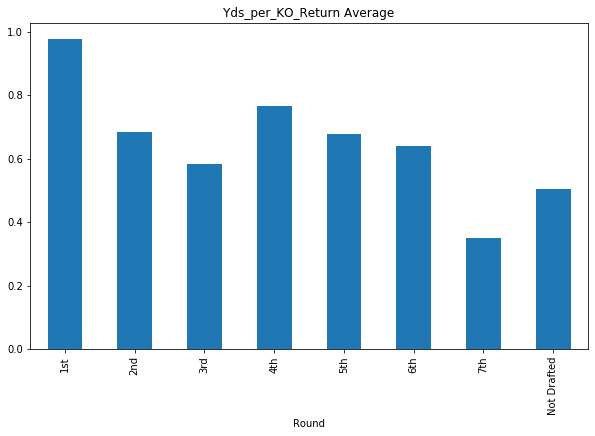

In [147]:
plot_stats_bar(df, puntret_stats)

In [148]:
for i in puntret_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df,  i)
    print('')
    print('*' * 40)

Kickoff_Returns ANOVA Test:
----------------------------------------
              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00    52.02     7.43 2.28    0.03
Residual 5484.00 17855.31     3.26  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.1293    0.9 -0.4498 0.1911  False
   1st         3rd  -0.1593  0.758 -0.4727 0.1541  False
   1st         4th   -0.078    0.9 -0.3929  0.237  False
   1st         5th   0.0422    0.9 -0.2845 0.3689  False
   1st         6th  -0.1211    0.9 -0.4627 0.2205  False
   1st         7th  -0.2547 0.3253 -0.5988 0.0895  False
   1st Not Drafted  -0.2313 0.1145 -0.4884 0.0257  False
   2nd         3rd    -0.03    0.9 -0.3512 0.2913  False
   2nd         4th   0.0514    0.9 -0.2715 0.3742  False
   2nd         5th   0.1716  0.749 -0.1627 0.5058  False
   2nd         6th   0.0083    0.9 -0.3406 0.

Not surprising, none of these features are significant between rounds. There isn't a ton of data for this section so I'm not shocked it's not dictating a pick.

### College Stats - Scoring

In [149]:
scoring_stats = ['Scoring_Games', 'TD_Other', 'Ttl_TDs', 'TwoPT_Conversion', 'Safety', 'TTL_Points', 'TD_OtherperGame',
                 'Ttl_TDsperGame', 'TwoPT_ConversionperGame', 'SafetyperGame', 'TTL_PointsperGame']

In [150]:
df[scoring_stats].describe()

,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame
count,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00,5492.00
mean,7.31,-0.00,3.01,0.00,0.00,19.59,-0.00,inf,inf,0.00,inf
std,5.96,0.03,4.98,0.07,0.03,31.30,0.00,nan,nan,0.00,nan
min,0.00,-1.00,0.00,0.00,0.00,0.00,-0.09,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,11.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.16
75%,13.00,0.00,4.00,0.00,0.00,30.00,0.00,0.38,0.00,0.00,2.57
max,15.00,0.00,32.00,2.00,1.00,192.00,0.00,inf,inf,0.09,inf


Once again I have pesky 'inf' values in my 'perGame' metrics. I'll have to drop these as well. This all goes back to missing game numbers for just a handful of observations for their final year of college play. Scoring data is also pretty sparse. Safetys and 2pt conversions are not that common so I doubt they'll end up being useful in my model.

In [156]:
scoring_stats = ['TwoPT_Conversion', 'Safety', 'TTL_Points']

TwoPT_Conversion Summary:
count   5492.00
mean       0.00
std        0.07
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: TwoPT_Conversion, dtype: float64
----------------------------------------
TwoPT_Conversion by Round
                  Round      
TwoPT_Conversion  1st           0.00
                  2nd           0.00
                  3rd           0.00
                  4th           0.01
                  5th           0.00
                  6th           0.00
                  7th           0.00
                  Not Drafted   0.01
dtype: float64


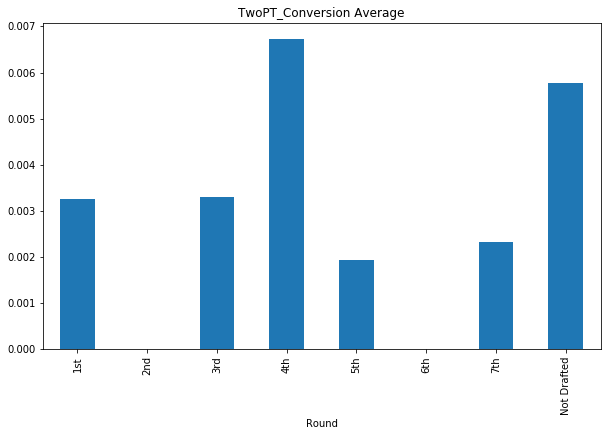

Safety Summary:
count   5492.00
mean       0.00
std        0.03
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Safety, dtype: float64
----------------------------------------
Safety by Round
        Round      
Safety  1st           0.00
        2nd           0.00
        3rd           0.00
        4th           0.00
        5th           0.00
        6th           0.00
        7th           0.00
        Not Drafted   0.00
dtype: float64


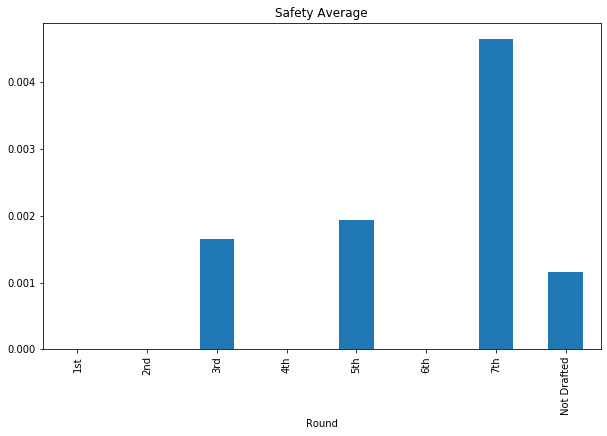

TTL_Points Summary:
count   5492.00
mean      19.59
std       31.30
min        0.00
25%        0.00
50%        2.00
75%       30.00
max      192.00
Name: TTL_Points, dtype: float64
----------------------------------------
TTL_Points by Round
            Round      
TTL_Points  1st           23.47
            2nd           22.96
            3rd           18.00
            4th           19.27
            5th           17.48
            6th           18.47
            7th           17.60
            Not Drafted   19.22
dtype: float64


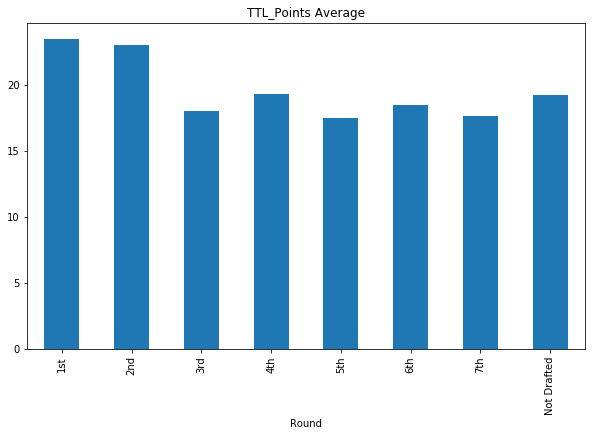

In [157]:
plot_stats_bar(df, scoring_stats)

In [155]:
for i in scoring_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey(df, i)
    print('')
    print('*' * 40)

TwoPT_Conversion ANOVA Test:
----------------------------------------
              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    0.03     0.00 0.95    0.46
Residual 5484.00   23.90     0.00  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0033    0.9  -0.015 0.0085  False
   1st         3rd      0.0    0.9 -0.0114 0.0115  False
   1st         4th   0.0035    0.9 -0.0081  0.015  False
   1st         5th  -0.0013    0.9 -0.0133 0.0106  False
   1st         6th  -0.0033    0.9 -0.0158 0.0092  False
   1st         7th  -0.0009    0.9 -0.0135 0.0117  False
   1st Not Drafted   0.0025    0.9 -0.0069 0.0119  False
   2nd         3rd   0.0033    0.9 -0.0085 0.0151  False
   2nd         4th   0.0067 0.6459 -0.0051 0.0185  False
   2nd         5th   0.0019    0.9 -0.0103 0.0142  False
   2nd         6th      0.0    0.9 -0.0128 0.01

As expected, the only feature that rejects the null is TTL Points. Now that I have validated my features, I can start to model.